# UQ for an Optical Potential!

One of the main motivations for building an emulator is to rapidly evaluate posteriors for Bayesian optimization and uncertainty-quantification. Often, our models have high dimensional parameter spaces, and are expensive to solve, making these analyzis computationally prohibitive. In this tutorial, we will use an emulator from `ROSE`, combined with the Bayesian optimization package `surmise`, which uses Markov-chain Monte Carlo (MCMC) to find the best fit values on the parameters space.



We will use the emulator with optimal configuration we found in the previous tutorial, with 7 basis elements and 7 terms in the affine decomposition: 

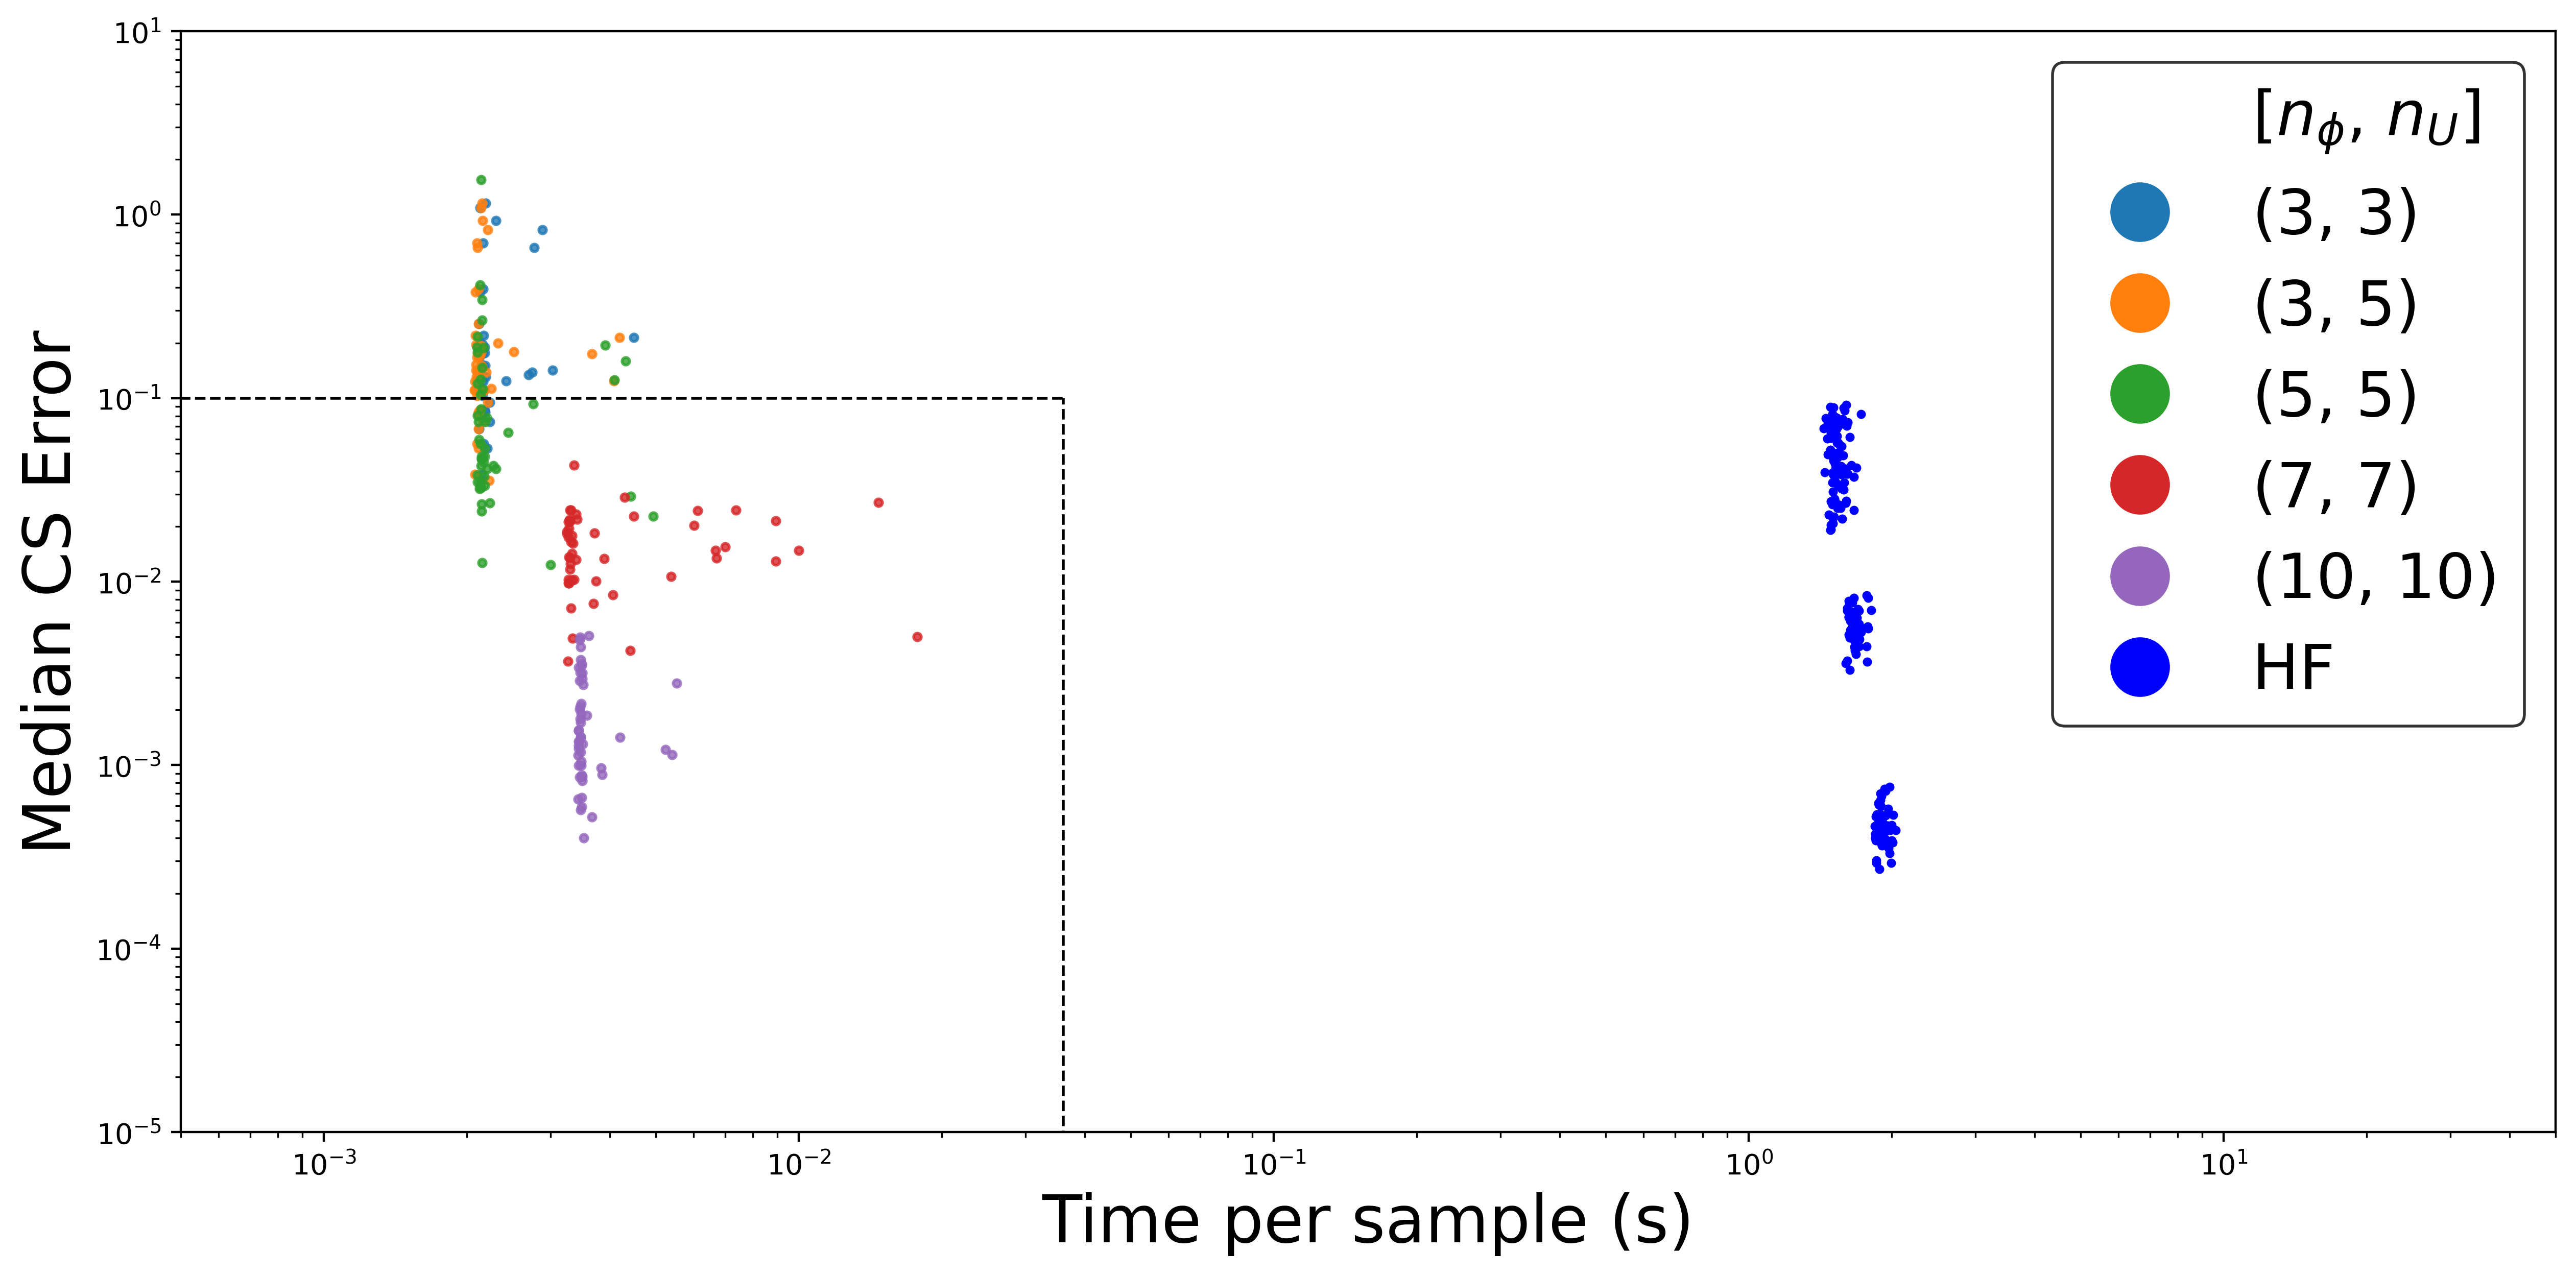

We see that the median of our emulator error was around 10^-2 and we will use that as a rough estimate of the expected error. Be mindful that, when selecting the emulator configuration (7,7) we used 50 test samples from a box of $20\%$ in the parameter space, and we expect that if our random walkers get to far from this training region the emulator quality will decrease.


First we quickly create our emulator, copying the problem setup from the previous tutorial:

In [3]:
# import ROSE to construct the emulator
# pip install --upgrade nuclear-rose
import rose

# other nice things
import numpy as np
import time
import os
from scipy.stats import qmc

# import stuff for nice plotting
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import scipy.stats as sps
from tqdm import tqdm
import random
import datetime
# !pip install corner
import corner

from scipy.stats import norm

import surmise
import importlib


import matplotlib.patches as mpatches
import matplotlib.lines as mlines


plt.rcParams.update({"font.size": 12})

In [4]:
print(surmise.__version__)

0.2.1


In [5]:
print(rose.__version__)

1.0.0


In [6]:
A = 40  # mass of the target

AMU = 931.494102  # MeV/c^2, Particle Data Group
MASS_N = 1.008665 * AMU  # MeV/c^2 PDG
MASS_P = 1.007276 * AMU  # MeV/c^2 PDG
MASS_CHARGED_PION = 139.57039  # MeV/c^2
B_40CA = 342.0522  # BMEX

MASS_40CA = 20 * MASS_P + 20 * MASS_N - B_40CA
MU = (
    MASS_40CA * MASS_N / (MASS_40CA + MASS_N)
)  # reduced mass - we will do calculations in COM frame

# asymptotic energy and wavenumber in center-of-mass (COM) frame
energy = 14  # MeV
k = np.sqrt(2 * MU * energy) / rose.constants.HBARC

#Charge of the target and projectile
Z1=20
Z2=1
#Charge radius of 40Ca
Rc=3.478

# how many partial waves should we calculate?
l_max = 10
l_list = list(range(l_max + 1))

# domain of the differential cross section; the observable we want to emulate
angles = np.linspace(1, 179, 179)
# ROSE also has a convenient grid over radial space we can steal
# rho = rose.constants.DEFAULT_RHO_MESH.copy()

rho=np.linspace(1e-6, 8*np.pi,2000)
# rho=np.linspace(1e-4, 8*np.pi,2000)
s_0=6 * np.pi

In [7]:
# shape of interaction for volume term
def wood_saxon(r, R, a):
    return 1 / (1 + np.exp((r - R) / a))


# shape of interaction for surface-peaked and spin-orbit coupling terms
def wood_saxon_prime(r, R, a):
    return -1 / a * np.exp((r - R) / a) / (1 + np.exp((r - R) / a)) ** 2


# total potential with a real and central term (with the same geometry)
# and imaginary surface-peaked term, but no SO coupling
def optical_potential(r, theta):
    Vv, Wv, Wd, Vso, Rv, Rd, Rso, av, ad, aso = theta
    return (-1j * Wv - Vv) * wood_saxon(r, Rv, av) + (4j * ad * Wd) * wood_saxon_prime(
        r, Rd, ad
    )


# spin orbit interaction constant
mso = rose.constants.HBARC / MASS_CHARGED_PION


# spin-orbit (SO) coulpling term - a function of l dot s, l being the orbital angular momentum
# and s being the spin of the neutron
def spin_orbit_potential(r, theta, ldots):
    Vv, Wv, Wd, Vso, Rv, Rd, Rso, av, ad, aso = theta
    return (Vso) * mso**2 * ldots * wood_saxon_prime(r, Rso, aso) / r


# the total number of parameters
nparams = 10

In [8]:
# This is the value of the parameters coming from the Koning-Delaroche parametrization.
# Taken from https://www-nds.iaea.org/RIPL-3/
VvKD = 55.5
WvKD = 1.1
WdKD = 7.8
VsoKD = 5.5
# WsoKD = -3.1

RvKD = 1.19* 40 ** (1.0 / 3.0)
RdKD = 1.29* 40 ** (1.0 / 3.0)
RsoKD = 1.00 * 40 ** (1.0 / 3.0)

avKD = 0.67
adKD = 0.54
asoKD = 0.59

alphaKD = np.array(
    [VvKD, WvKD, WdKD, VsoKD, RvKD, RdKD, RsoKD, avKD, adKD, asoKD]
)



#The following are the center of the parameters to train the emulator


Vv0 = 50
Wv0 = 2
Wd0 = 5
Vso = 5



Rv0 = 4

Rd0 = 4
Rso = 4

av0 = 0.5

ad0 = 0.5
aso = 0.5
    
    
    

#This is the center of our prior and around where we will train our RBM emulator
alphaCentral = np.array([Vv0, Wv0, Wd0, Vso, Rv0, Rd0, Rso, av0 , ad0, aso])




scaleTraining = 0.3

bounds = np.array(
    [
        alphaCentral - np.fabs(alphaCentral * scaleTraining),
        alphaCentral + np.fabs(alphaCentral * scaleTraining),
    ]
).T


def sample_points(npoints, bounds,initial_seed=None):
    sampler = qmc.LatinHypercube(d=len(bounds), seed=initial_seed)
    sample = sampler.random(npoints)
    scaled = qmc.scale(sample, bounds[:, 0], bounds[:, 1])
    return scaled

In [9]:
n_train = 200

seed_train=142857
training_samples = sample_points(n_train, bounds,initial_seed=seed_train)
np.savetxt("train_params_calibration_protons.txt",training_samples)

In [10]:
n_train_EIM=1000

seed_EIM=142857*3

train_EIM = sample_points(n_train_EIM, bounds,initial_seed=seed_EIM)
np.savetxt("train_params_EIM_calibration_protons.txt",train_EIM)

In [11]:
n_test=100
seed_test=142857*2

test_samples = sample_points(n_test, bounds,initial_seed=seed_test)


np.savetxt("test_params_calibration_protons.txt",test_samples)

In [10]:
test_samples=np.loadtxt("test_params_calibration_protons.txt")

Great, we have our potential and parameters set up. Before we create our emulator, let's take a look at the experimental data we want to fit.

We will build our emulator to predict the CS over the fine grid of angles so we can have relatively continous plots in the end, but we need to be sure that when calibrating with the data, the ROSE emulator is predicting only on the 14 actual points of data.

In [12]:
n_basis = 15
n_eim = 15

interactions = rose.InteractionEIMSpace(
    optical_potential,
    nparams,
    MU,
    energy,
    l_max,
    Z_1=Z1, Z_2=Z2, R_C=Rc,
    training_info=train_EIM,
    is_complex=True,
    spin_orbit_potential=spin_orbit_potential,
    explicit_training = True,
    rho_mesh=rho,
    n_basis=n_eim,
)



In [13]:

saeMCMC_fullangles = rose.ScatteringAmplitudeEmulator.from_train(
    interactions,
    training_samples,
    l_max,
    s_mesh=rho,
    s_0=s_0,
    n_basis=n_basis,
    angles=angles/ 180 * np.pi,
    hf_tols=[
        10 ** (-9),
        10 ** (-9),
    ],
)

100%|███████████████████████████████████████████████████████████████████████████████████| 11/11 [01:26<00:00,  7.89s/it]


In [14]:
# calculate the exact differential cross section for the 50 test parameters we sampled
test_CS = []
for params in tqdm(test_samples):
    test_CS.append(saeMCMC_fullangles.exact_dsdo(params))

100%|█████████████████████████████████████████████████████████████████████████████████| 100/100 [05:27<00:00,  3.28s/it]


In [15]:
np.savetxt("test_CS_calibration_protons.txt",test_CS)

In [16]:
test_CS=np.loadtxt("test_CS_calibration_protons.txt")

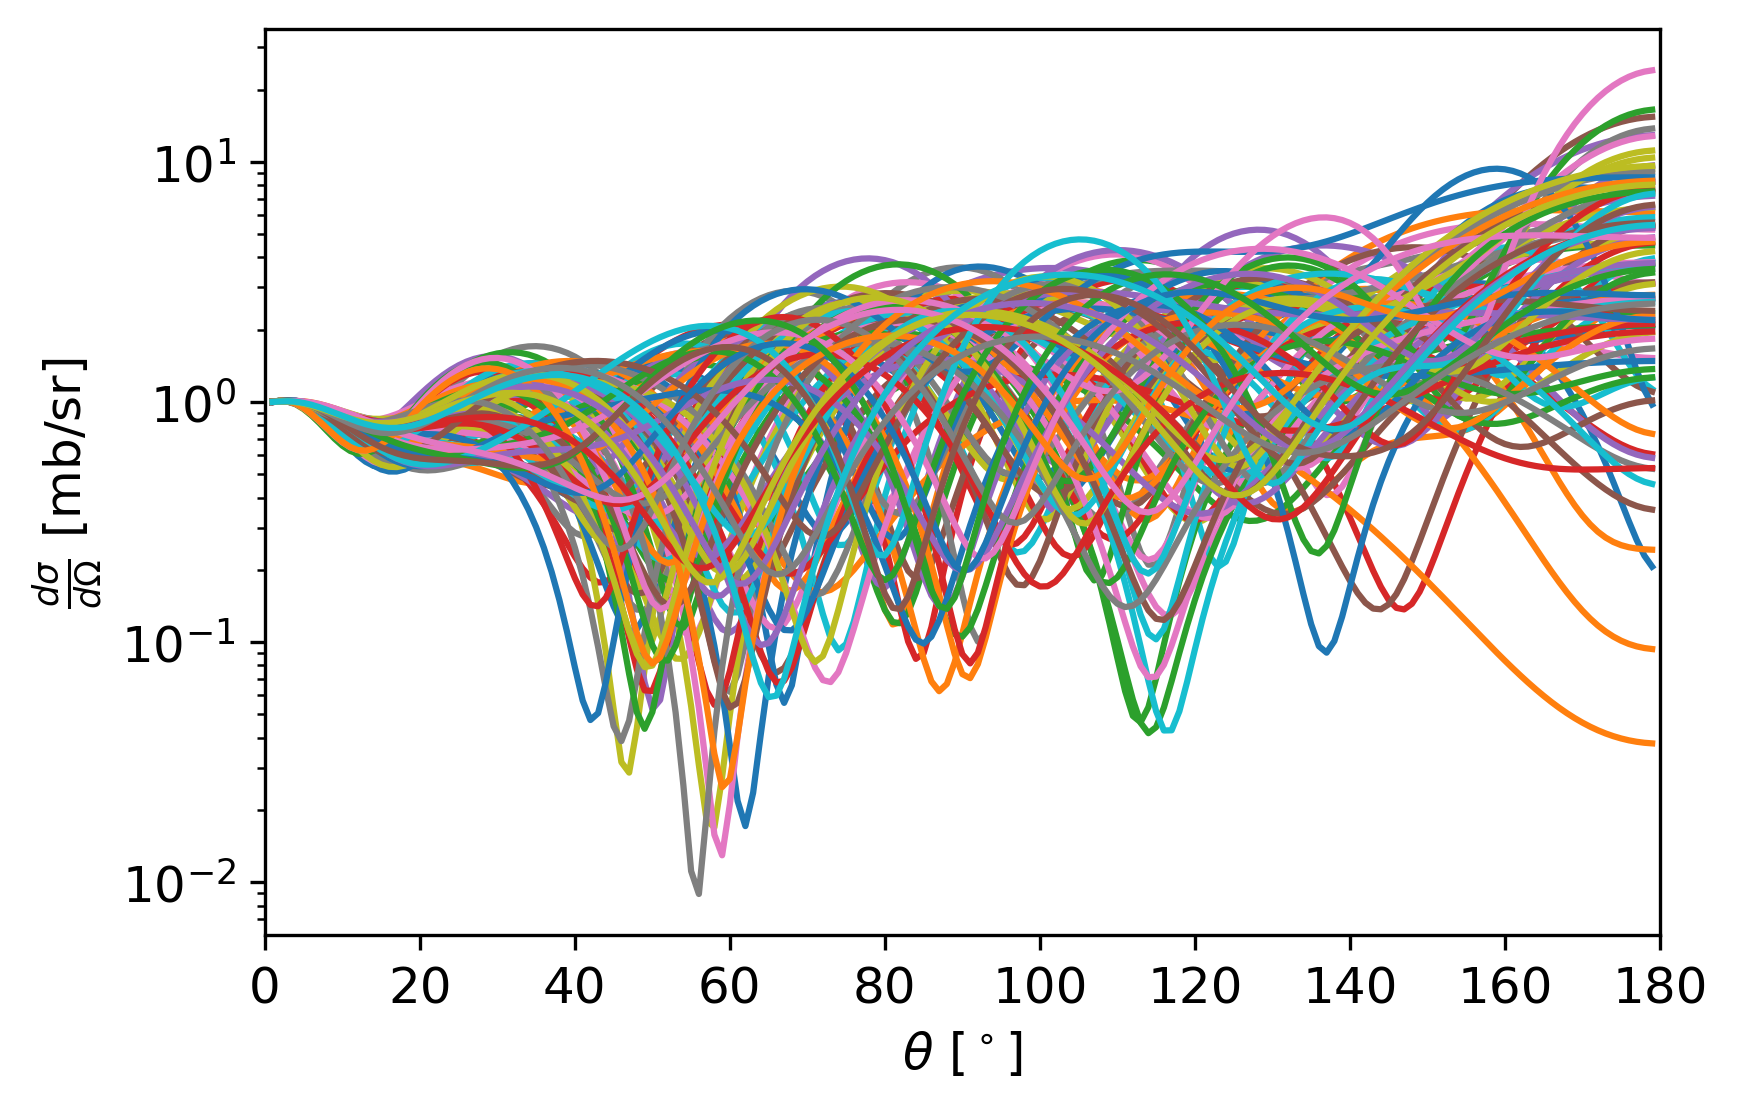

In [17]:
# now let's plot the differential scattering cross section for each of these samples test points!
fig, ax = plt.subplots(figsize=(6, 4), dpi=300)
fig.patch.set_facecolor("white")


for i in range(n_test):
    ax.plot(angles, test_CS[i])
ax.set_yscale("log")
plt.xlim([0, 180])
plt.xlabel(r"$\theta$ [$^\circ$]")
plt.ylabel(r"$\frac{d \sigma}{d \Omega}$ [mb/sr]")
plt.show()

In [18]:
prediction_list = []
times_list = []
for i in range(len(test_samples)):
        st = time.time()
        predicted = saeMCMC_fullangles.emulate_dsdo(test_samples[i])
        et = time.time()
        prediction_list.append(predicted)
        times_list.append(et - st)

residual_list_relative = []
residual_list_all = []
residual_list_median = []


#Calculating residuals over all the angles:
for i in range(len(test_samples)):
    residual_list_relative.append(
        np.fabs((prediction_list[i] - test_CS[i])) / (test_CS[i])
    )
    residual_list_median.append(np.median(residual_list_relative[i]))
    residual_list_all.append(prediction_list[i] - test_CS[i])


In [19]:
residual_list_all=np.array(residual_list_all)

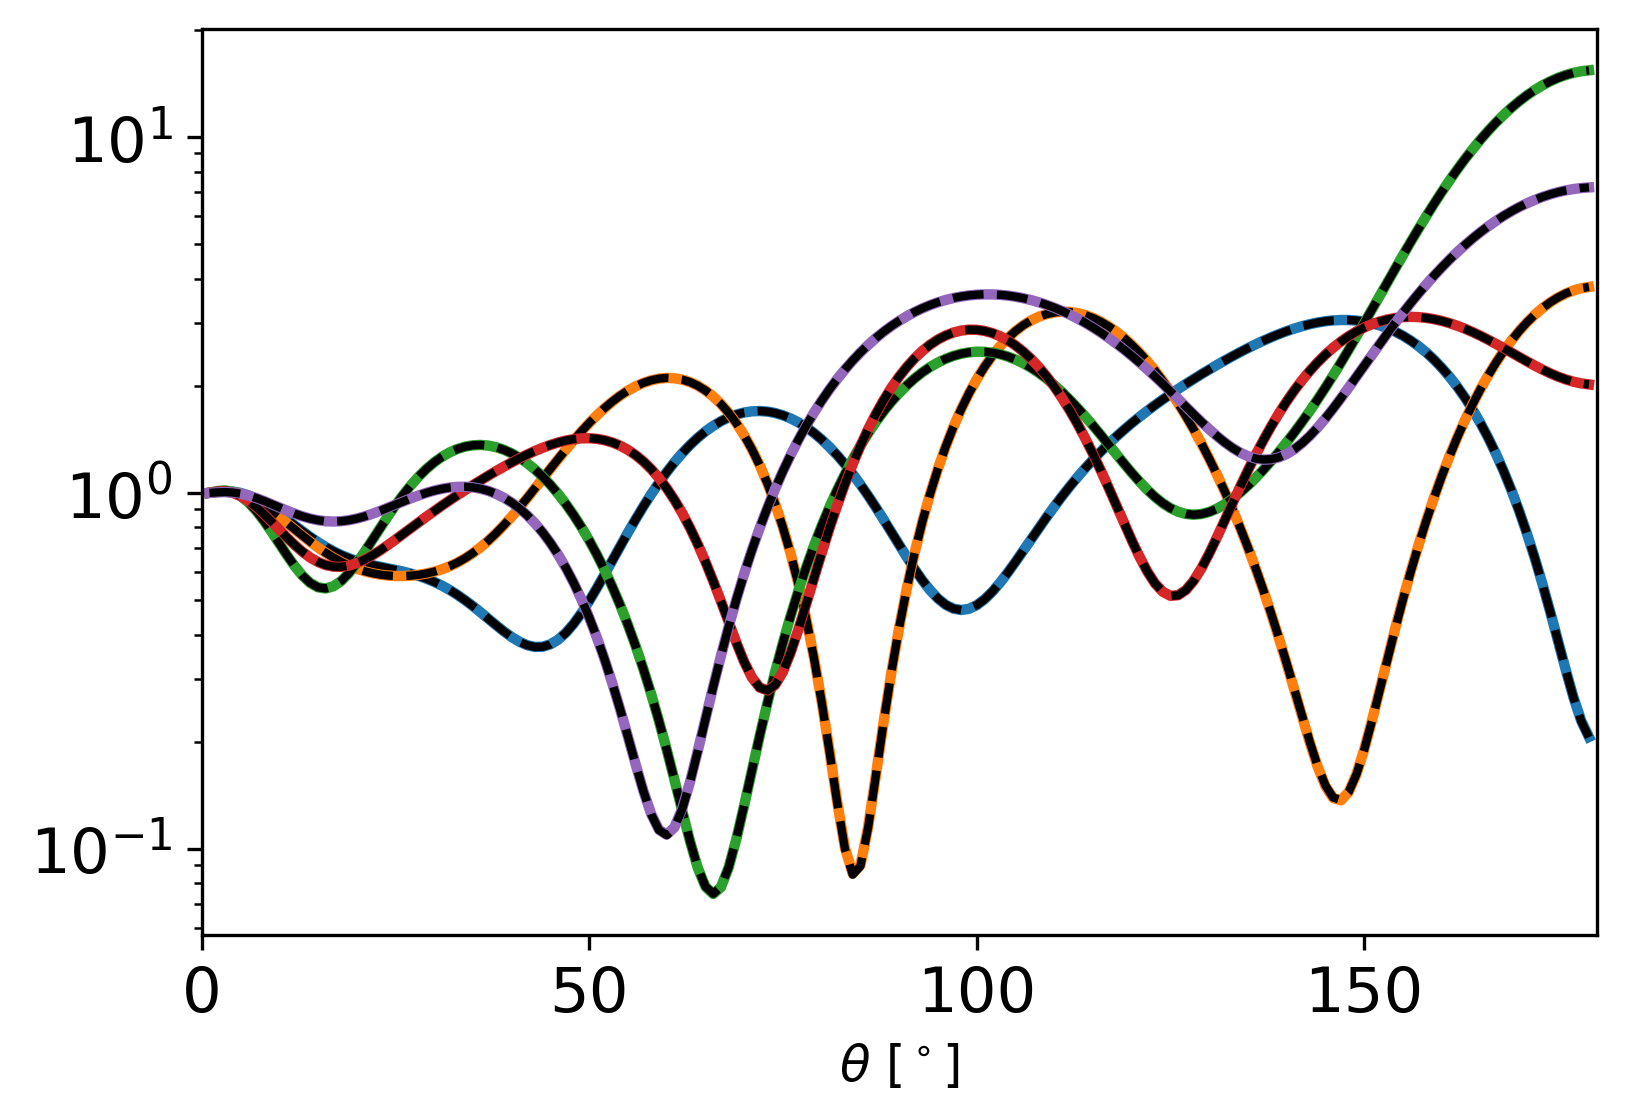

In [22]:
fig, ax = plt.subplots(figsize=(6, 4), dpi=300)
fig.patch.set_facecolor("white")

listvals=[0,3,5,10,4]

# for i in range(15):
for i in listvals:
    p = ax.plot(angles, test_CS[i],linewidth=2.5)
    ax.plot(angles, prediction_list[i], linestyle= "dashed" ,color='k',linewidth=2)

    # ax.plot(angles, test_CS[i])
    # ax.plot(angles, test_CS_emu[i], linestyle= "dashed" )

legend_styles = [
    Line2D([0], [0], color="k", linestyle="--"),
    Line2D([0], [0], color="k"),
]
# ax.legend(legend_styles, ["ROSE", "Runge-Kutta"],fontsize=15)
ax.set_yscale("log")
plt.rc("xtick", labelsize=15)
plt.rc("ytick", labelsize=15)
plt.xlim([0, 180])
plt.xlabel(r"$\theta$ [$^\circ$]")
# plt.ylabel(r"$\frac{d \sigma}{d \Omega}$ [mb/sr]",fontsize=20,labelpad=-75)
plt.show()

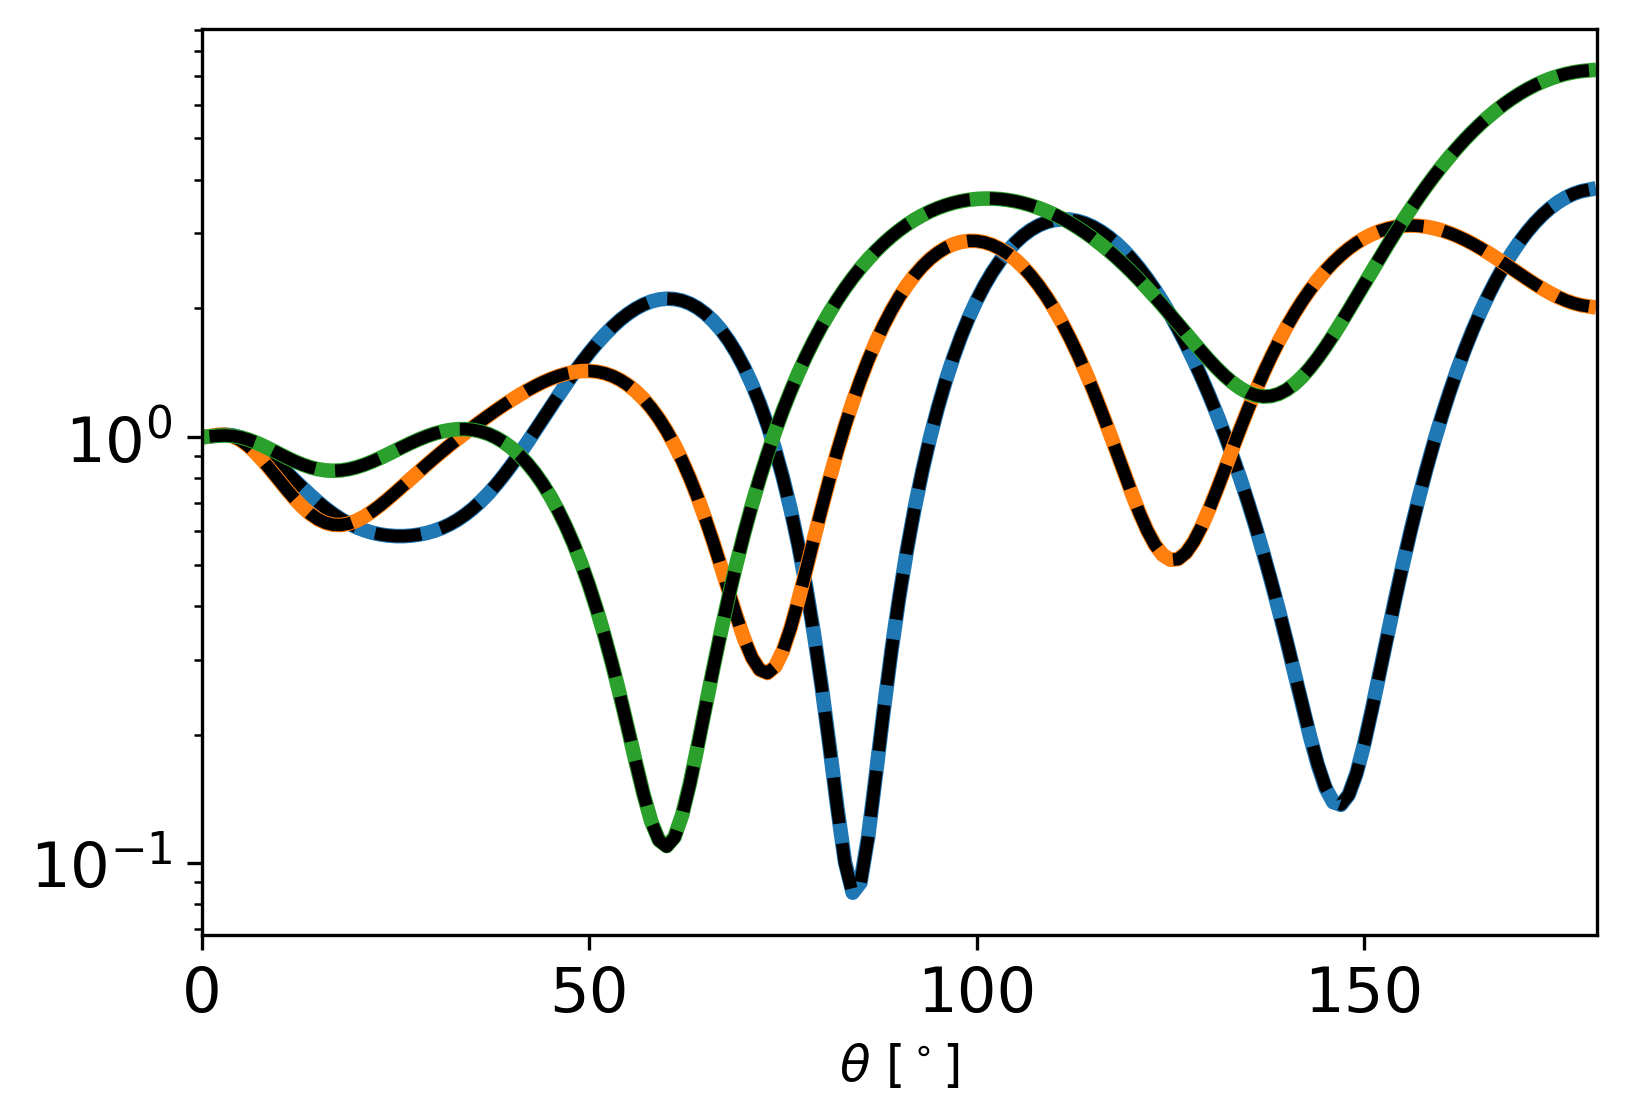

In [23]:
fig, ax = plt.subplots(figsize=(6, 4), dpi=300)
fig.patch.set_facecolor("white")

listvals=[3,10,4]

# for i in range(15):
for i in listvals:
    p = ax.plot(angles, test_CS[i],linewidth=3.5)
    ax.plot(angles, prediction_list[i], linestyle= "dashed" ,color='k',linewidth=3)

    # ax.plot(angles, test_CS[i])
    # ax.plot(angles, test_CS_emu[i], linestyle= "dashed" )

legend_styles = [
    Line2D([0], [0], color="k", linestyle="--"),
    Line2D([0], [0], color="k"),
]
# ax.legend(legend_styles, ["ROSE", "Runge-Kutta"],fontsize=15)
ax.set_yscale("log")
plt.rc("xtick", labelsize=15)
plt.rc("ytick", labelsize=15)
plt.xlim([0, 180])
plt.xlabel(r"$\theta$ [$^\circ$]")
# plt.ylabel(r"$\frac{d \sigma}{d \Omega}$ [mb/sr]",fontsize=20,labelpad=-75)
plt.show()

## Generating the pseudo data

In [24]:
#Percentage error to be used in the cs
sigma_err=0.1

# Defining the data we are interest in

#Angles Matched to reproduce Figure 6 from: https://iopscience.iop.org/article/10.1088/1361-6471/abba72

angles_theta=np.arange(20,160,5)


anglesX=angles_theta- np.full(len(angles_theta), 1) #Moving the angles location by one because of how python works
f_exact = saeMCMC_fullangles.exact_dsdo(alphaKD)

# X = np.array(anglesindexs)

# anglesX=np.array(angles)[X]*180/np.pi

# anglesX=np.array(X)



In [25]:

yperfect =f_exact[anglesX]


In [26]:
yerr=yperfect*sigma_err

In [27]:
np.random.seed(142857)

y_measured=[]

for i in range(len(yperfect)):
    y_measured.append(yperfect[i]+np.random.normal(0, yperfect[i]*sigma_err))

In [28]:
y_measured=np.array(y_measured)

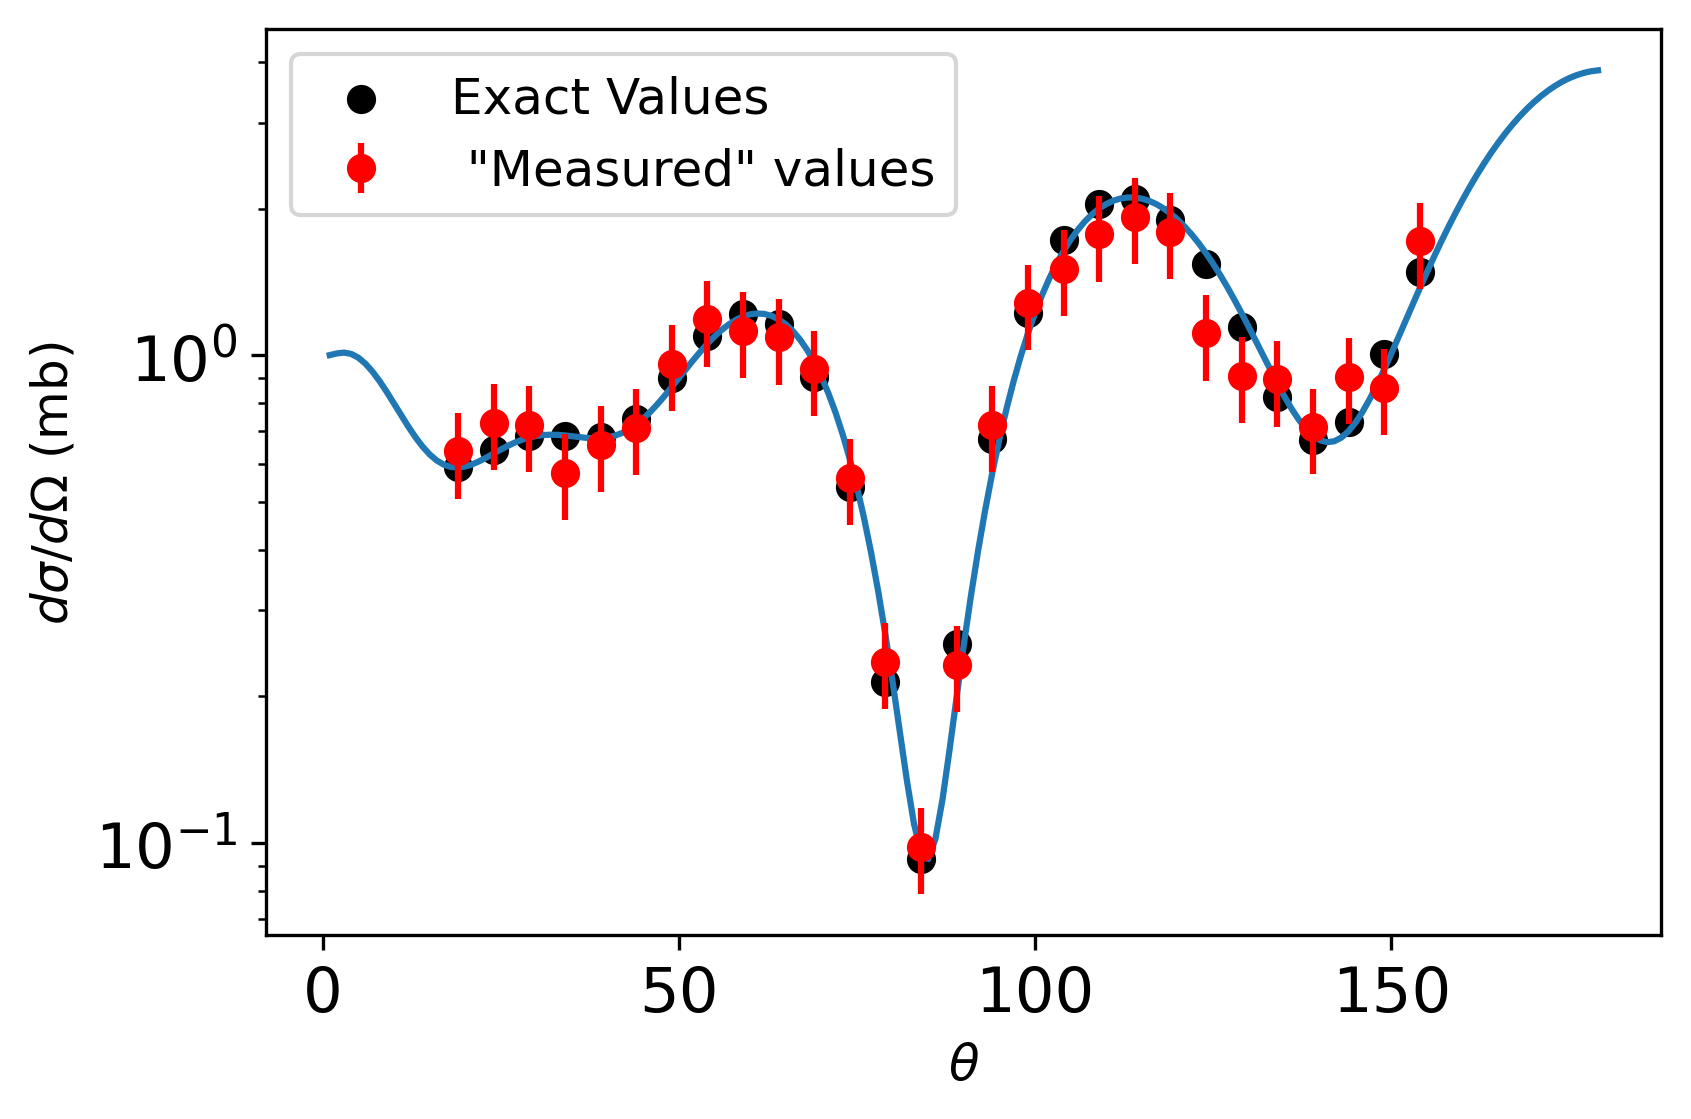

In [29]:
fig, ax = plt.subplots(figsize=(6,4),dpi=300)
fig.patch.set_facecolor('white')


ax.plot(angles,f_exact)
ax.scatter(anglesX, yperfect,color='k',label='Exact Values')
# ax.scatter(anglesX, y_measured,color='r',label=' "Measured" values')
ax.errorbar(anglesX, y_measured, yerr=np.array(y_measured)*0.2, fmt="o", c="r",label=' "Measured" values')

ax.legend()

ax.set_yscale('log')
ax.set_xlabel(r'$\theta$')
ax.set_ylabel(r'$d\sigma/d\Omega$ (mb)');

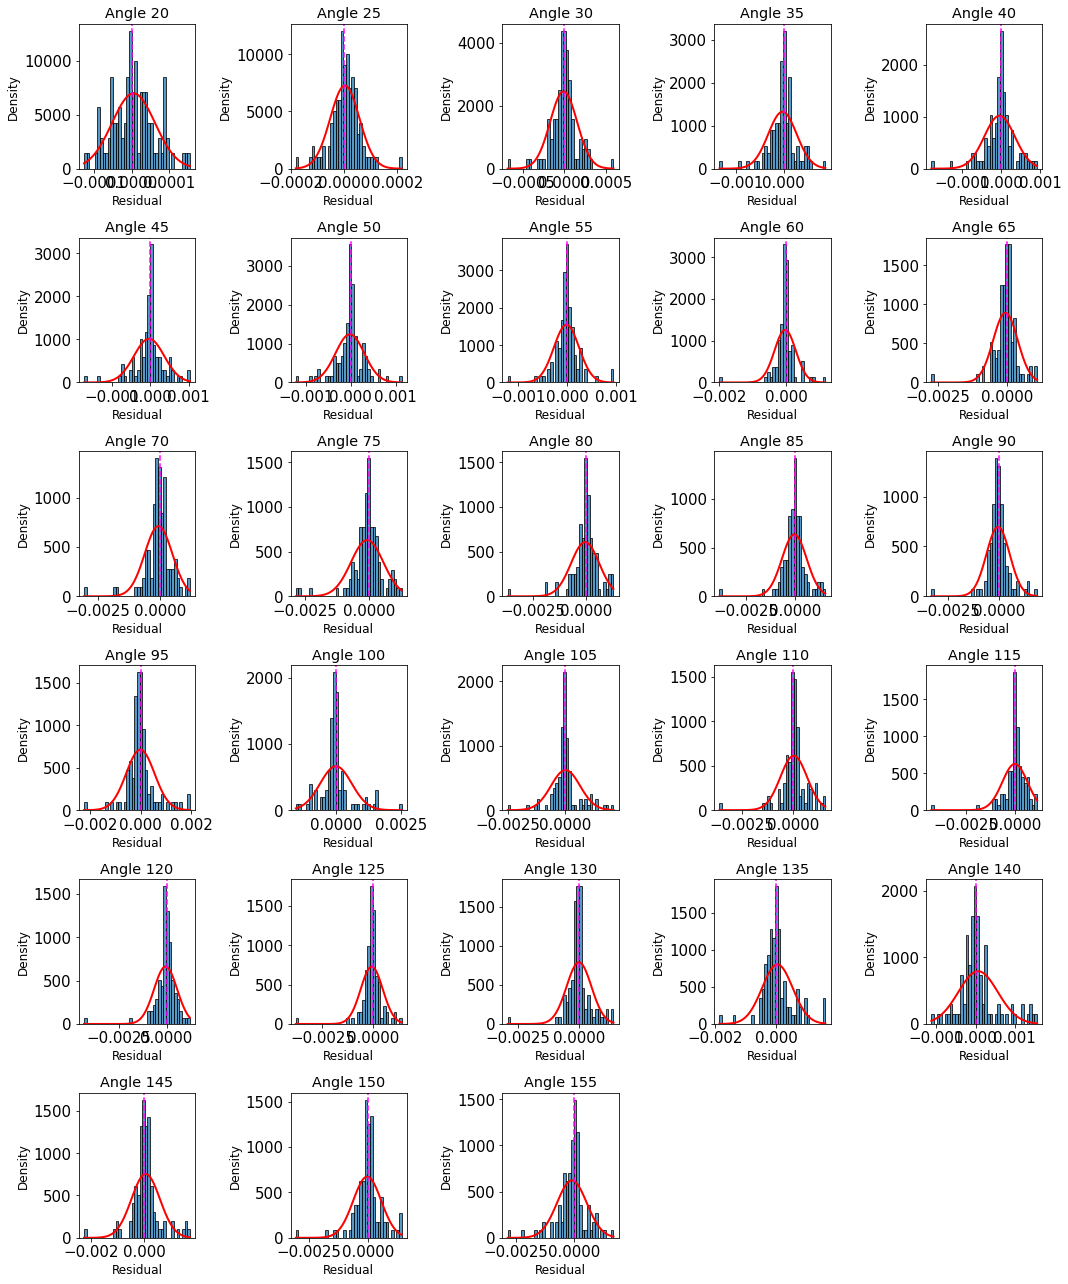

In [30]:

rmse_list=[]
residuals=residual_list_all.T[anglesX]

plots_per_row = 5
num_of_rows = len(residuals) // plots_per_row + (len(residuals) % plots_per_row > 0)

# Set up the figure size, you can adjust it as needed
plt.figure(figsize=(15, num_of_rows * 3))

# Loop over the list of residuals and create a histogram for each
for i, residual in enumerate(residuals):
    # Create a subplot for each histogram
    ax=plt.subplot(num_of_rows, plots_per_row, i + 1)
    
#     # Plot the histogram
#     plt.hist(residual, bins=20, alpha=0.75, edgecolor='black', density=True)
    
    # Plot the histogram and normalize it
    ax.hist(residual, bins=40, alpha=0.75, edgecolor='black', density=True)

    
    
    # Fit a Gaussian distribution to the residuals
    mu=np.mean(residuals[i])
    std = np.std(residuals[i])
    rmse_list.append(np.sqrt(mu**2+std**2))

    
    # Plot the Gaussian distribution
    xmin=np.min(residuals[i])
    xmax = np.max(residuals[i])

    x = np.linspace(xmin, xmax, 100)
    p = norm.pdf(x, mu, std)
    ax.plot(x, p, 'r', linewidth=2)
    
                     
                     
    ax.axvline(x=0, color='magenta', linestyle='--', linewidth=1.5)
    # Optional: Set a title or labels
    plt.title(f'Angle {anglesX[i]+1}')
    plt.xlabel('Residual')
    plt.ylabel('Density')
    
    # Optional: Set a tight layout so the plots are neatly arranged
    plt.tight_layout()

# Show the plot
plt.show()

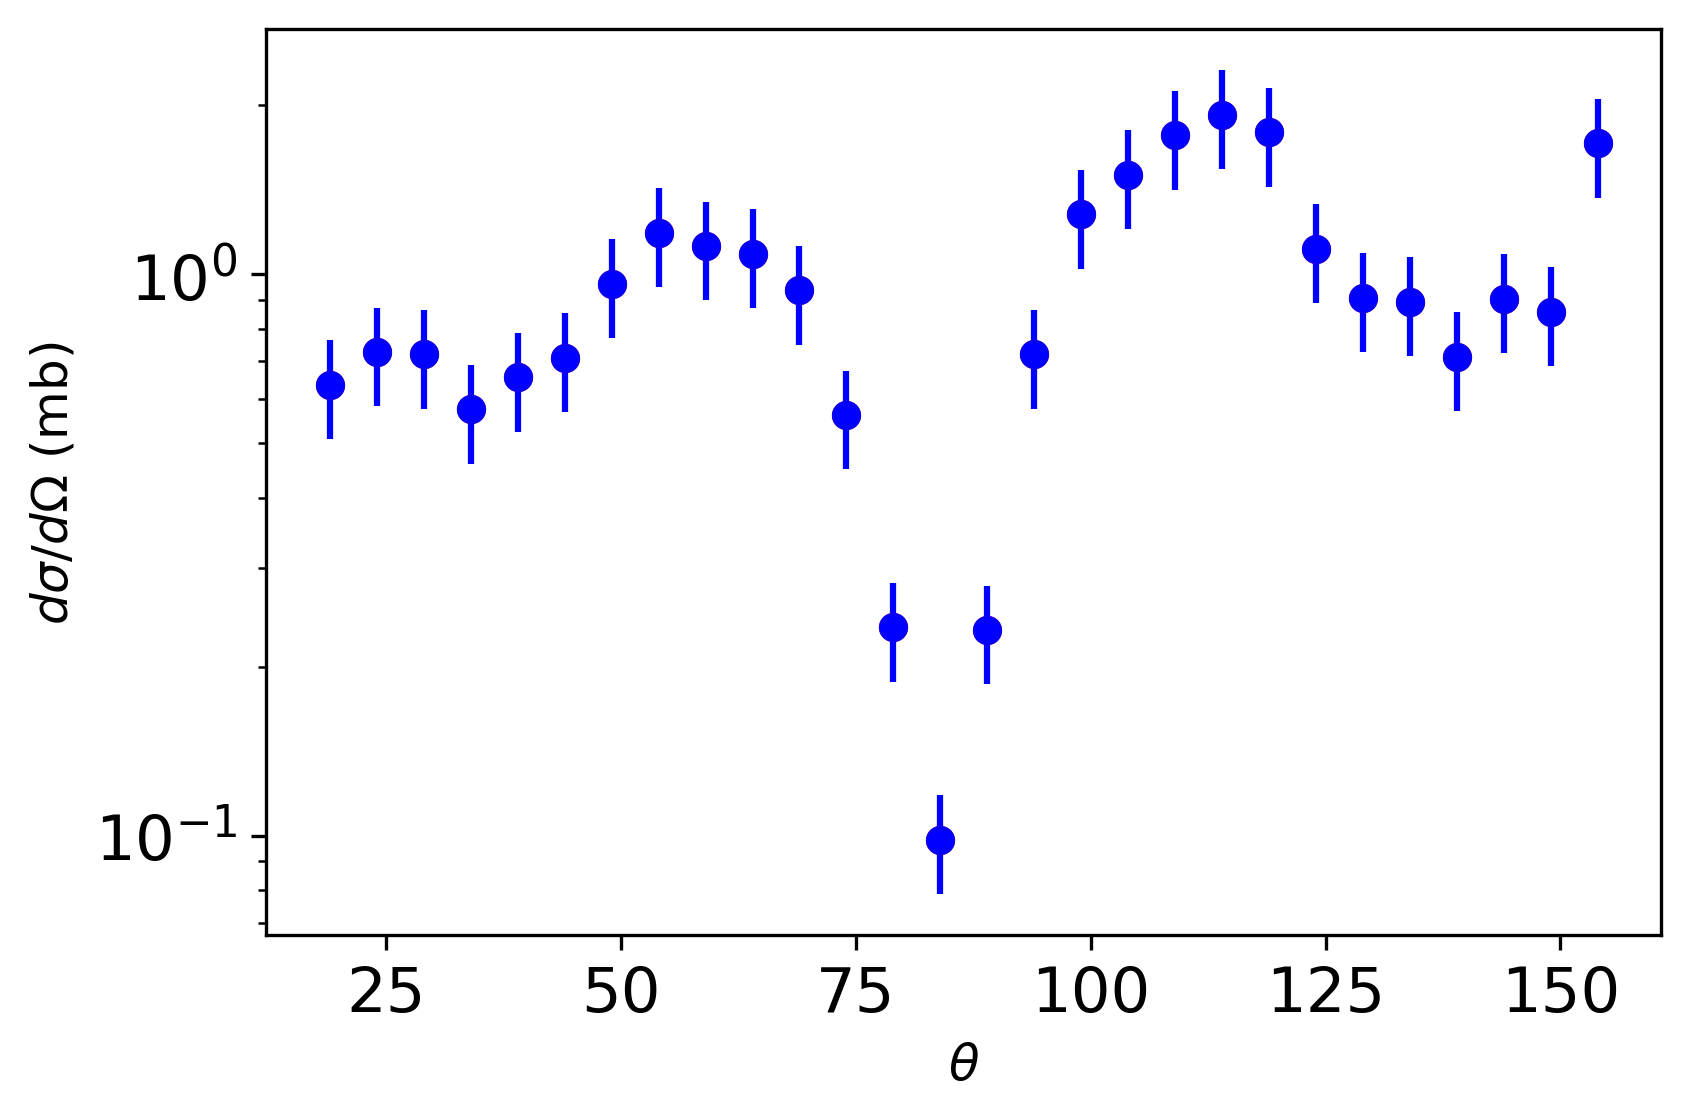

In [32]:
fig, ax = plt.subplots(figsize=(6,4),dpi=300)
fig.patch.set_facecolor('white')


ax.errorbar(anglesX, y_measured, yerr=np.array(rmse_list)*10, fmt="o", c="r")
ax.errorbar(anglesX, y_measured, yerr=np.array(y_measured)*0.2, fmt="o", c="b")

ax.set_yscale('log')
ax.set_xlabel(r'$\theta$')
ax.set_ylabel(r'$d\sigma/d\Omega$ (mb)');

In [28]:
# np.savetxt("rmse_list_calibration.txt",rmse_list)

## Specifying the Prior

In [33]:
# In this default we are assuming uncorrelated Gaussian priors. Advanced users can provide covariance matrices for correlations

# Specifying the priors, we believe the answer that explains the data shouldn't be too far away from the KD parameters
alphaCentralPrior = alphaCentral

#We are using Gaussian priors with a standard deviation of 15% of their respective centers
SigmasPrior = [abs(param_val * 0.25) for param_val in alphaCentralPrior]

# We use a smaller scale for the starting values of the MCMC chains so that we minimize the chances of one
# starting in a negative value of the diffuseness or the radii

#This scale is very important: since the optical potential posterior parameter surface is highly multimodal we would like to limit ourself for this tutorial
#to study a vicinity of the main mode closer to our prior. We will start our walkers very close to the prior center.
MCMCScale = [abs(param_val * 0.05) for param_val in alphaCentralPrior]

#This error scale comes from the CAT plot we showed at the begining. The factor of 5 is to be overly conservative and reduce the chance of under-estimation
# Emulator_Error=5*10**(-2)
#Alternatively, we might decide to use the list of errors obtained before to be more precise on each angle
Emulator_error_list=np.copy(rmse_list)

## Going Bayesian with Surmise

We will use surmise, another BAND-developed package for connecting all the tools and softwares (such as our ROSE emulator) for performing Bayesian analysis.

Check out surmise's documentation webpage for more information: https://surmise.readthedocs.io/en/latest/

Our sample rate for the emulator is around 3 miliseconds, which means around 20k samples per minute. We are choosing a relatively small amount of samples and chains to have the calibration done in a couple of minutes. You can of course run it for longer and obtain millions of samples to build very detailed and rich corner plots.

In [34]:
from surmise.emulation import emulator
from surmise.calibration import calibrator

X = np.copy(angles_theta)/180*np.pi
# X = np.copy(anglesX)
y = np.copy(y_measured)
# y = np.copy(yperfect)
# yerr = np.copy(dxs_err) # err in data

# obsvar = 1.0 * np.square(yerr) + np.square(Emulator_error_list)
#At the end we didn't use the emulator's error to be more conservative, adding a 1% error because of it
obsvar = 1.0 * np.square(yerr) + 1.0 * np.square(0.1*yerr)

StepSizes0 = 0.007 * np.abs( alphaCentral )

numsamp = 50000
total_chains = 20
numcores = 8
BurnSamples0 = 3000

In [35]:
class prior_scattering:
    """ This defines the class instance of priors provided to the method. """


    def lpdf(theta):
        
        total_prior_pdf=sps.norm.logpdf(theta[:, 0], alphaCentralPrior[0],SigmasPrior[0] )
        
        for i in range(1,len(alphaCentralPrior)):
            total_prior_pdf=total_prior_pdf+ sps.norm.logpdf(theta[:, i], alphaCentralPrior[i],SigmasPrior[i] )
            
            
            
        return (total_prior_pdf).reshape((len(theta), 1))


    def rnd(n):
        totalRandomSamples=[]
        for i in range(len(alphaCentralPrior)):
            totalRandomSamples.append(sps.norm.rvs( alphaCentralPrior[i], MCMCScale[i],   size=n))
        
        totalRandomSamplesNumpy=np.array(totalRandomSamples)
        
        return totalRandomSamplesNumpy.T
        
def calibration_runner(rbm,x,y,obsvar,test_params,numsamp,i,caldir):
   
    cal = calibrator(emu=rbm,
                   y=y,
                   x=x,
                   thetaprior=prior_scattering, 
                   method='directbayes',
                   yvar=obsvar, 
                   args={
                       'theta0': test_params.reshape(1,nparams),
                       'sampler': 'metropolis_hastings',
                       'numsamp' : numsamp,
                       'stepType' : 'normal',
                       'stepParam' : StepSizes0,
                       'burnSamples' : BurnSamples0,
                       'verbose': True
                   })
                       
 
    calfile = os.path.join(caldir,"caltheta_{}.out".format(i))
    np.savetxt(calfile,cal.info['thetarnd'])

    return cal.info['thetarnd']

In [36]:
random.seed(142857)



caldir = os.path.join(
    os.getcwd(), "Cal-" + datetime.datetime.now().strftime("%Y-%m-%d_%H-%M")
)
os.makedirs(caldir, exist_ok=True)

rand_params = prior_scattering.rnd(total_chains)

In [97]:
# def rbm_emulator(x,theta):
# #     if (theta.shape[0]==1):
        
# #         return saeMCMC_fullangles.emulate_dsdo(theta)[x]
# #     else:

#         return np.array([saeMCMC_fullangles.emulate_dsdo(theta[i])[x]  for i in range(len(theta))]).T


In [98]:
# X= np.copy(angles_theta) / 180 * np.pi

In [23]:
# all_chains=np.loadtxt("Cal-2023-12-11_22-34/caltheta_0.out")

# for i in range(1,20):
#     all_chains=np.vstack(
#         (
#             all_chains,
#             np.loadtxt(f"Cal-2023-12-11_22-34/caltheta_{i}.out"),
#         )
#     )

In [37]:
rbm = emulator(method='nuclear-ROSE', args={'rose_emu': saeMCMC_fullangles, 
#                                             'emu_variance_constant': Emulator_Error, 
                                            'angle_atol': 1e-1
                                           })

In [38]:

# rbm.predict(theta=alphaKD.reshape(1, len(alphaKD)),x=X).mean()
# rbm = emulator(x=X, theta=alphaCentralPrior, passthroughfunc=rbm_emulator)


st = time.time()
sep_chains = []
chain0 = calibration_runner(rbm, X, y, obsvar, rand_params[0], numsamp, 0, caldir)
sep_chains.append(chain0)
all_chains = chain0

for ij in tqdm(range(total_chains - 1)):
    current_cal = calibration_runner(
        rbm, X, y, obsvar, rand_params[ij], numsamp, ij + 1, caldir
    )

    all_chains = np.vstack(
        (
            all_chains,
            current_cal,
        )
    )
    
    sep_chains.append(current_cal)

    print("Percentage Completed ", int((ij + 1) / (total_chains - 1) * 100))
    
sep_chains = np.array(sep_chains)
et = time.time()
print("Total time:", et - st)

/home/pablo/.local/lib/python3.10/site-packages/surmise/utilitiesmethods/metropolis_hastings.py:80: RuntimeWarning: overflow encountered in exp
  p_accept = min(1, np.exp(logpost - lposterior[i-1]))


At sample 30000, acceptance rate is 0.22163333333333332.
Final Acceptance Rate:  0.2461


  0%|                                                                                            | 0/19 [00:00<?, ?it/s]/home/pablo/.local/lib/python3.10/site-packages/surmise/utilitiesmethods/metropolis_hastings.py:80: RuntimeWarning: overflow encountered in exp
  p_accept = min(1, np.exp(logpost - lposterior[i-1]))


At sample 30000, acceptance rate is 0.2312.
Final Acceptance Rate:  0.25236


  5%|████▎                                                                              | 1/19 [02:57<53:07, 177.07s/it]

Percentage Completed  5


/home/pablo/.local/lib/python3.10/site-packages/surmise/utilitiesmethods/metropolis_hastings.py:80: RuntimeWarning: overflow encountered in exp
  p_accept = min(1, np.exp(logpost - lposterior[i-1]))


At sample 30000, acceptance rate is 0.2253.
Final Acceptance Rate:  0.25236


 11%|████████▋                                                                          | 2/19 [05:55<50:20, 177.68s/it]

Percentage Completed  10


/home/pablo/.local/lib/python3.10/site-packages/surmise/utilitiesmethods/metropolis_hastings.py:80: RuntimeWarning: overflow encountered in exp
  p_accept = min(1, np.exp(logpost - lposterior[i-1]))


At sample 30000, acceptance rate is 0.21906666666666666.
Final Acceptance Rate:  0.24796


 16%|█████████████                                                                      | 3/19 [09:03<48:37, 182.34s/it]

Percentage Completed  15


/home/pablo/.local/lib/python3.10/site-packages/surmise/utilitiesmethods/metropolis_hastings.py:80: RuntimeWarning: overflow encountered in exp
  p_accept = min(1, np.exp(logpost - lposterior[i-1]))


At sample 30000, acceptance rate is 0.21693333333333334.
Final Acceptance Rate:  0.24558


 21%|█████████████████▍                                                                 | 4/19 [12:03<45:21, 181.41s/it]

Percentage Completed  21


/home/pablo/.local/lib/python3.10/site-packages/surmise/utilitiesmethods/metropolis_hastings.py:80: RuntimeWarning: overflow encountered in exp
  p_accept = min(1, np.exp(logpost - lposterior[i-1]))


At sample 30000, acceptance rate is 0.2255.
Final Acceptance Rate:  0.25224


 26%|█████████████████████▊                                                             | 5/19 [15:04<42:21, 181.55s/it]

Percentage Completed  26


/home/pablo/.local/lib/python3.10/site-packages/surmise/utilitiesmethods/metropolis_hastings.py:80: RuntimeWarning: overflow encountered in exp
  p_accept = min(1, np.exp(logpost - lposterior[i-1]))


At sample 30000, acceptance rate is 0.21956666666666666.
Final Acceptance Rate:  0.24518


 32%|██████████████████████████▏                                                        | 6/19 [18:09<39:35, 182.73s/it]

Percentage Completed  31


/home/pablo/.local/lib/python3.10/site-packages/surmise/utilitiesmethods/metropolis_hastings.py:80: RuntimeWarning: overflow encountered in exp
  p_accept = min(1, np.exp(logpost - lposterior[i-1]))


At sample 30000, acceptance rate is 0.22743333333333332.
Final Acceptance Rate:  0.24566


 37%|██████████████████████████████▌                                                    | 7/19 [21:12<36:32, 182.68s/it]

Percentage Completed  36


/home/pablo/.local/lib/python3.10/site-packages/surmise/utilitiesmethods/metropolis_hastings.py:80: RuntimeWarning: overflow encountered in exp
  p_accept = min(1, np.exp(logpost - lposterior[i-1]))


At sample 30000, acceptance rate is 0.2285.
Final Acceptance Rate:  0.2511


 42%|██████████████████████████████████▉                                                | 8/19 [24:15<33:29, 182.69s/it]

Percentage Completed  42


/home/pablo/.local/lib/python3.10/site-packages/surmise/utilitiesmethods/metropolis_hastings.py:80: RuntimeWarning: overflow encountered in exp
  p_accept = min(1, np.exp(logpost - lposterior[i-1]))


At sample 30000, acceptance rate is 0.2167.
Final Acceptance Rate:  0.24552


 47%|███████████████████████████████████████▎                                           | 9/19 [27:19<30:31, 183.14s/it]

Percentage Completed  47


/home/pablo/.local/lib/python3.10/site-packages/surmise/utilitiesmethods/metropolis_hastings.py:80: RuntimeWarning: overflow encountered in exp
  p_accept = min(1, np.exp(logpost - lposterior[i-1]))


At sample 30000, acceptance rate is 0.22426666666666667.
Final Acceptance Rate:  0.24888


 53%|███████████████████████████████████████████▏                                      | 10/19 [30:22<27:29, 183.22s/it]

Percentage Completed  52


/home/pablo/.local/lib/python3.10/site-packages/surmise/utilitiesmethods/metropolis_hastings.py:80: RuntimeWarning: overflow encountered in exp
  p_accept = min(1, np.exp(logpost - lposterior[i-1]))


At sample 30000, acceptance rate is 0.22186666666666666.
Final Acceptance Rate:  0.25086


 58%|███████████████████████████████████████████████▍                                  | 11/19 [33:27<24:29, 183.66s/it]

Percentage Completed  57


/home/pablo/.local/lib/python3.10/site-packages/surmise/utilitiesmethods/metropolis_hastings.py:80: RuntimeWarning: overflow encountered in exp
  p_accept = min(1, np.exp(logpost - lposterior[i-1]))


At sample 30000, acceptance rate is 0.2265.
Final Acceptance Rate:  0.25254


 63%|███████████████████████████████████████████████████▊                              | 12/19 [36:35<21:34, 184.95s/it]

Percentage Completed  63
At sample 30000, acceptance rate is 0.2193.
Final Acceptance Rate:  0.24296


 68%|████████████████████████████████████████████████████████                          | 13/19 [39:46<18:40, 186.78s/it]

Percentage Completed  68


/home/pablo/.local/lib/python3.10/site-packages/surmise/utilitiesmethods/metropolis_hastings.py:80: RuntimeWarning: overflow encountered in exp
  p_accept = min(1, np.exp(logpost - lposterior[i-1]))


At sample 30000, acceptance rate is 0.22443333333333335.
Final Acceptance Rate:  0.24934


 74%|████████████████████████████████████████████████████████████▍                     | 14/19 [43:16<16:09, 193.92s/it]

Percentage Completed  73
At sample 30000, acceptance rate is 0.22643333333333332.
Final Acceptance Rate:  0.25272


 79%|████████████████████████████████████████████████████████████████▋                 | 15/19 [46:52<13:22, 200.61s/it]

Percentage Completed  78


/home/pablo/.local/lib/python3.10/site-packages/surmise/utilitiesmethods/metropolis_hastings.py:80: RuntimeWarning: overflow encountered in exp
  p_accept = min(1, np.exp(logpost - lposterior[i-1]))


At sample 30000, acceptance rate is 0.22583333333333333.
Final Acceptance Rate:  0.2496


 84%|█████████████████████████████████████████████████████████████████████             | 16/19 [50:36<10:22, 207.58s/it]

Percentage Completed  84


/home/pablo/.local/lib/python3.10/site-packages/surmise/utilitiesmethods/metropolis_hastings.py:80: RuntimeWarning: overflow encountered in exp
  p_accept = min(1, np.exp(logpost - lposterior[i-1]))


At sample 30000, acceptance rate is 0.2253.
Final Acceptance Rate:  0.25144


 89%|█████████████████████████████████████████████████████████████████████████▎        | 17/19 [54:20<07:05, 212.55s/it]

Percentage Completed  89


/home/pablo/.local/lib/python3.10/site-packages/surmise/utilitiesmethods/metropolis_hastings.py:80: RuntimeWarning: overflow encountered in exp
  p_accept = min(1, np.exp(logpost - lposterior[i-1]))


At sample 30000, acceptance rate is 0.22606666666666667.
Final Acceptance Rate:  0.24882


 95%|█████████████████████████████████████████████████████████████████████████████▋    | 18/19 [58:04<03:35, 215.99s/it]

Percentage Completed  94


/home/pablo/.local/lib/python3.10/site-packages/surmise/utilitiesmethods/metropolis_hastings.py:80: RuntimeWarning: overflow encountered in exp
  p_accept = min(1, np.exp(logpost - lposterior[i-1]))


At sample 30000, acceptance rate is 0.2171.
Final Acceptance Rate:  0.24054


100%|████████████████████████████████████████████████████████████████████████████████| 19/19 [1:01:42<00:00, 194.85s/it]

Percentage Completed  100
Total time: 3875.0078399181366


In [102]:
# #Getting the same number of samples from the prior so we can compare the two
# samples_prior=[]
# for i in range(len(alphaCentralPrior)):
#         samples_prior.append(sps.norm.rvs(alphaCentralPrior[i], SigmasPrior[i], size=1000000))
        
# samples_prior=np.array(samples_prior).T
        


## Plotting the results of the calibration

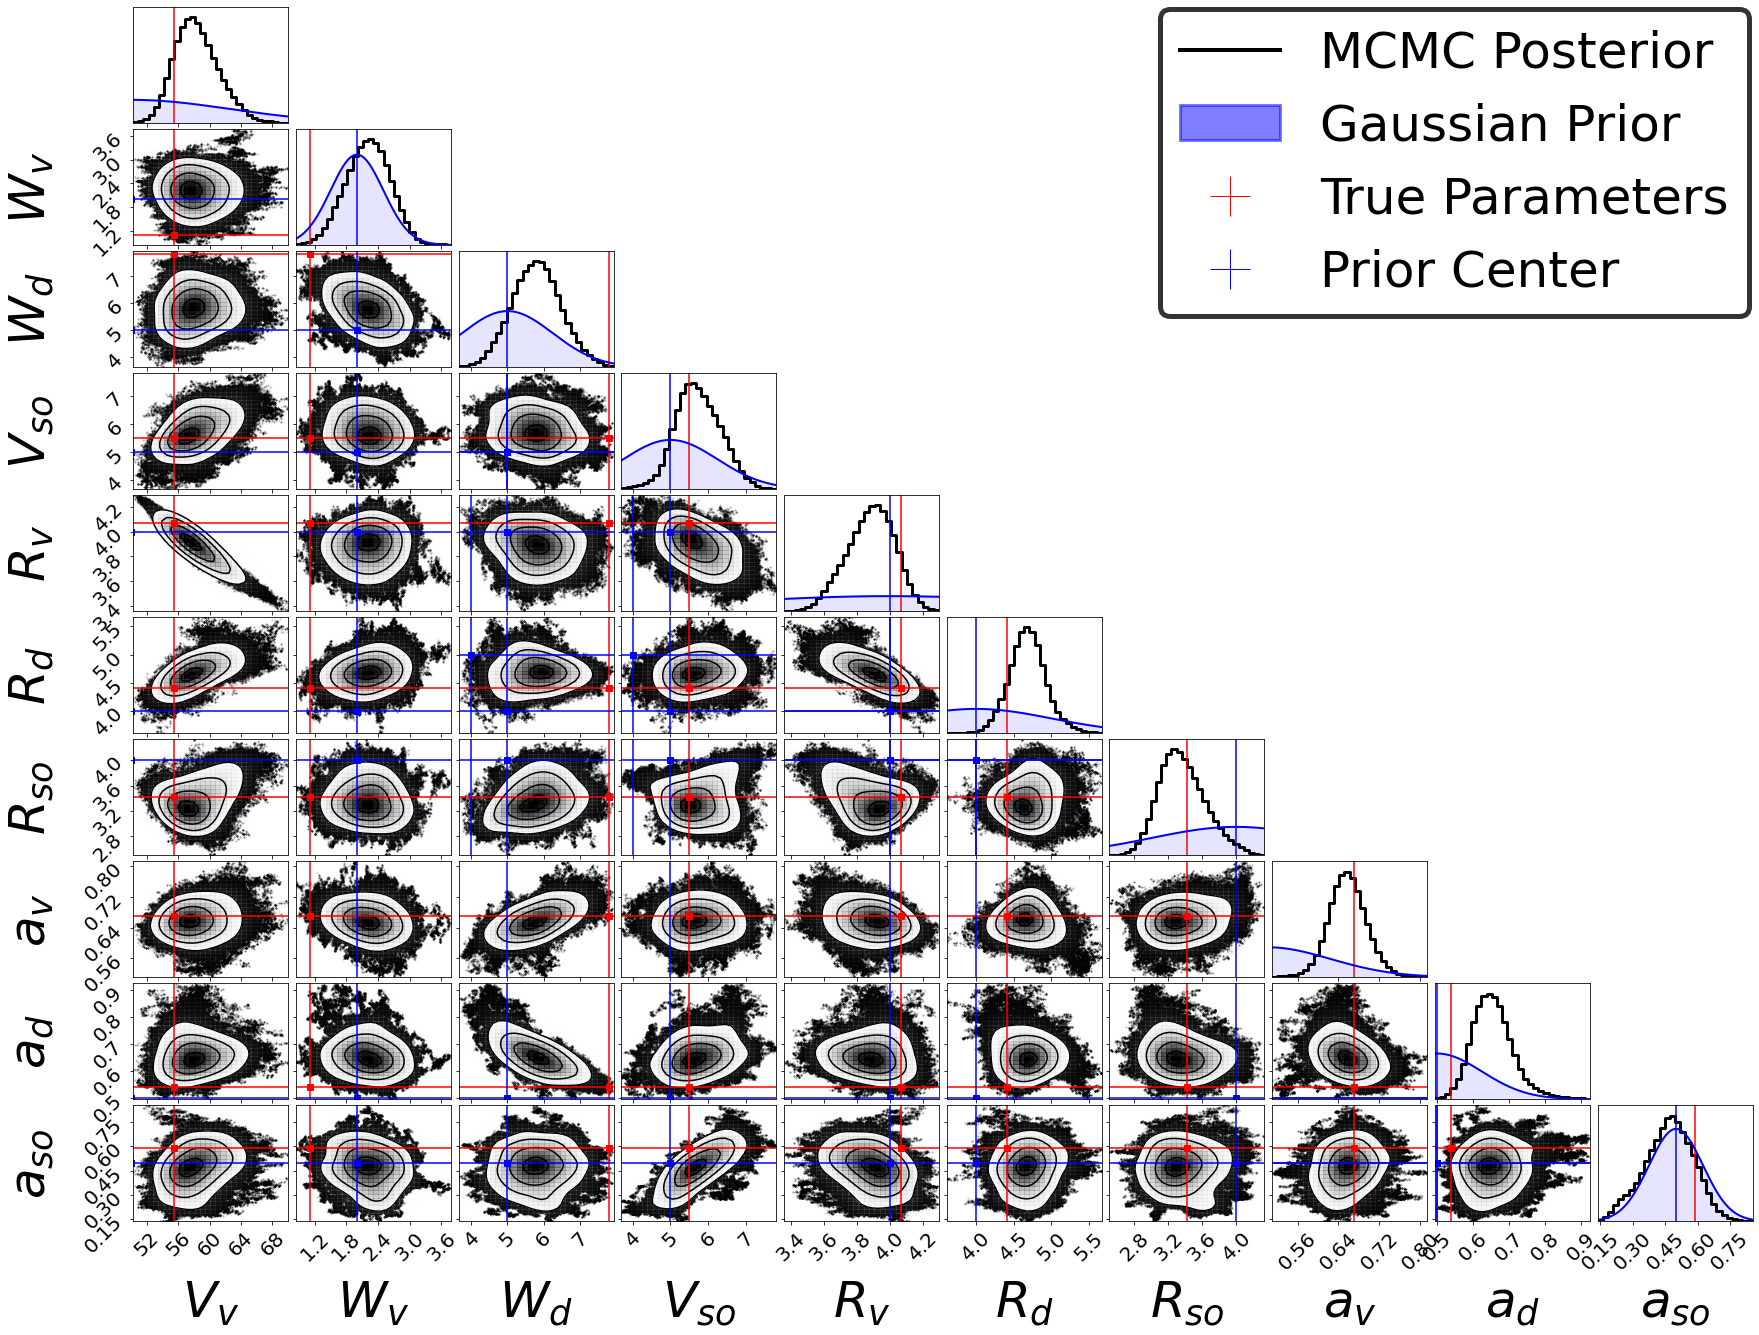

In [40]:
# The plotting routinge to make the gorgeous corner plots! For some reason we have to run it twice to make the label
# size for the ticks to be correct

plt.rc("xtick", labelsize=20)
plt.rc("ytick", labelsize=20)

bins_target=30
ws = [abs(max(all_chains[:,i])-min(all_chains[:,i]))/bins_target for i in range(len(all_chains.T))]

# figure=corner.corner(samples_prior,
#     labels=[
#         "$V_v$",
#         "$W_v$",
#         "$W_d$",
#         "$V_{so}$",
# #         "$W_{so}$",
#         "$R_v$",
#         "$R_d$",
#         "$R_{so}$",
#         "$a_v$",
#         "$a_d$",
#         "$a_{so}$"
#     ],
#     labelpad=0.2,
#     weights=np.full(len(samples_prior),(len(all_chains))/(len(samples_prior))),
#     bins=[int(abs(max(samples_prior[:,i])-min(samples_prior[:,i]))/ws[i]) for i in range(len(samples_prior.T))],
#     color='b',
#     # bins=20,
#     label_kwargs={"fontsize": 50},
#     hist_kwargs={"linewidth": 3},
#     quantiles=None,
#     truths=alphaCentral,
#     truth_color="cyan",
#     smooth=(1.7),
#     smooth1d=1.0
# )


# corner.corner(
#     all_chains,fig=figure,
figure=corner.corner(all_chains,
    labels=[
        "$V_v$",
        "$W_v$",
        "$W_d$",
        "$V_{so}$",
#         "$W_{so}$",
        "$R_v$",
        "$R_d$",
        "$R_{so}$",
        "$a_v$",
        "$a_d$",
        "$a_{so}$"
    ],
    labelpad=0.2,
    # bins=20,
    bins=[int(abs(max(all_chains[:,i])-min(all_chains[:,i]))/ws[i]) for i in range(len(all_chains.T))],
    label_kwargs={"fontsize": 50},
    hist_kwargs={"linewidth": 3},
    quantiles=None,
    truths=alphaKD,
    truth_color="r",
    smooth=(1.7),
    smooth1d=1.0
)


dim=len(all_chains[0]) 
ranges=[[min(all_chains[:,i]),max(all_chains[:,i])] for i in range(len(all_chains.T))]


axes = np.array(figure.axes).reshape((dim, dim))
# print()
for i in range(dim):
    ax = axes[i, i]
    ax.set_xlim(ranges[i][0],ranges[i][1])
    ax.axvline(alphaCentral[i], color="blue",label='Prior Center')
   

    x_grid=np.linspace(ranges[i][0],ranges[i][1],200)
    ax.plot(x_grid,len(all_chains)*ws[i]*norm.pdf(x_grid, alphaCentral[i], SigmasPrior[i]),color='b',linewidth=2)
    ax.fill_between(x_grid, len(all_chains)*ws[i]*norm.pdf(x_grid, alphaCentral[i], SigmasPrior[i]), color='blue', alpha=0.1)




    for j in range(i):
        ax = axes[i, j]
        ax.set_ylim(ranges[i][0],ranges[i][1])
        ax.set_xlim(ranges[j][0],ranges[j][1])
        
        
        ax.axvline(alphaCentral[i], color="blue")
        ax.axhline(alphaCentral[j], color="blue")
        ax.plot(alphaCentral[i], alphaCentral[j], "sb")
        
        
        ax.axvline(alphaCentral[j], color="blue")
        ax.axhline(alphaCentral[i], color="blue")
        ax.plot(alphaCentral[j], alphaCentral[i], "sb")


        
# filled_patch = mpatches.Patch(color='blue',alpha=0.3,linewidth=3)

filled_patch = mpatches.Patch(facecolor='blue', edgecolor='blue',alpha=0.5,linewidth=3)

cross1 = mlines.Line2D([], [], color='red', marker='+',linestyle='None',linewidth=5,
                       markersize=40)
cross2 = mlines.Line2D([], [], color='blue', marker='+',linestyle='None',linewidth=5,
                       markersize=40)

cross_with_square = plt.Line2D([0], [0], color='red', marker='P', linestyle='None', markersize=10, label='Cross with Square')


custom_lines = [plt.Line2D([0], [0], color='black', lw=4),
               filled_patch,cross1,cross2]



width = 24
height = 18
figure.set_size_inches(width, height)

# figure.legend(custom_lines, ['MCMC Posterior', 'Gaussian Prior', 'True Parameters','Prior Center'], fontsize='50',loc='upper right'
#               ,bbox_to_anchor=(1,1), borderaxespad=0.
#              )
legend = figure.legend(custom_lines, ['MCMC Posterior', 'Gaussian Prior', 'True Parameters', 'Prior Center'],
                       fontsize='50', loc='upper right', bbox_to_anchor=(0.98, 0.98), borderaxespad=0.)
legend.get_frame().set_edgecolor('black')
# Now, set the linewidth of the legend's frame.
frame = legend.get_frame()  # Get the frame.
frame.set_linewidth(5.0)  # Set the frame's linewidth to 2 points, or any value you prefer.



# figure.legend(handles=legend_elements, loc='upper right', bbox_to_anchor=(0.9, 0.9), bbox_transform=fig.transFigure)

# # We use the top-right subplot to anchor our legend to.
# top_right_ax = axes[0, -1]

# # Create a legend on the top-right axes, with the legend outside the plot area.
# # 'bbox_to_anchor' specifies the coordinates for the legend relative to the axes.
# # The coordinates (1.05, 1) here mean that the legend's bottom-left corner is just outside the top-right corner of the top-right axes.
# top_right_ax.legend(['Label1', 'Label2'], loc='upper left', bbox_to_anchor=(1.05, 1), borderaxespad=0.)

# # Adjust the figure to make space for the legend.
# plt.subplots_adjust(top=0.85)





plt.show()


Very interesting! In red we can see the original parametrization by Koning-Delaroche that we used as the center of our prior, the blue lines are the actual prior, and the black ones the posterior. Most parameters are more or less around that value, while some shifted appreciably.Some parameters are very well constrained by the data, while others seem to just be constrained by the prior. 

Thanks to ROSE, we now can make these kinds of analysis VERY fast!

In [39]:
from matplotlib.ticker import MaxNLocator

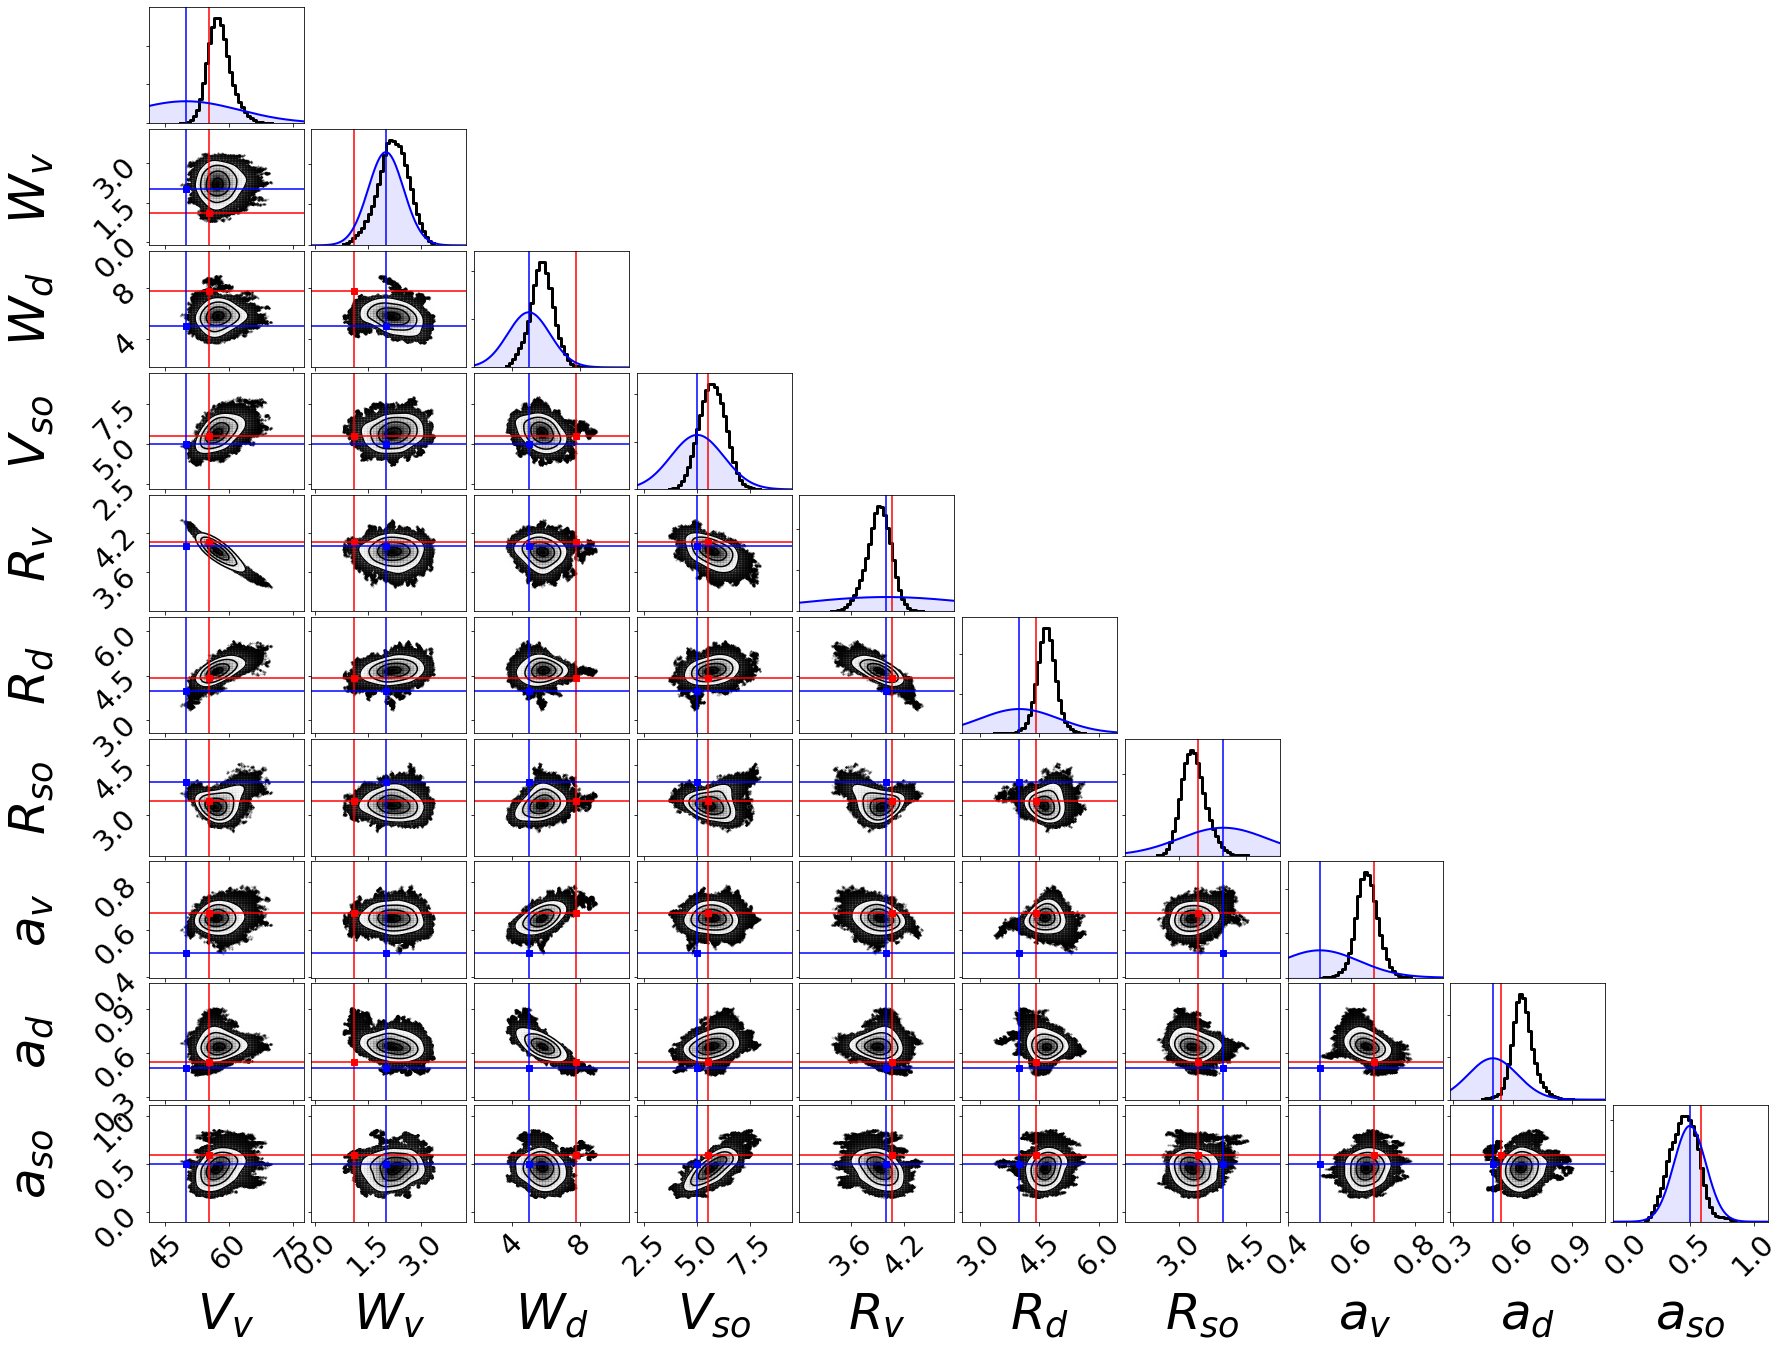

In [40]:
# The plotting routinge to make the gorgeous corner plots! For some reason we have to run it twice to make the label
# size for the ticks to be correct

plt.rc("xtick", labelsize=29)
plt.rc("ytick", labelsize=29)

bins_target=30
ws = [abs(max(all_chains[:,i])-min(all_chains[:,i]))/bins_target for i in range(len(all_chains.T))]

# figure=corner.corner(samples_prior,
#     labels=[
#         "$V_v$",
#         "$W_v$",
#         "$W_d$",
#         "$V_{so}$",
# #         "$W_{so}$",
#         "$R_v$",
#         "$R_d$",
#         "$R_{so}$",
#         "$a_v$",
#         "$a_d$",
#         "$a_{so}$"
#     ],
#     labelpad=0.2,
#     weights=np.full(len(samples_prior),(len(all_chains))/(len(samples_prior))),
#     bins=[int(abs(max(samples_prior[:,i])-min(samples_prior[:,i]))/ws[i]) for i in range(len(samples_prior.T))],
#     color='b',
#     # bins=20,
#     label_kwargs={"fontsize": 50},
#     hist_kwargs={"linewidth": 3},
#     quantiles=None,
#     truths=alphaCentral,
#     truth_color="cyan",
#     smooth=(1.7),
#     smooth1d=1.0
# )


# corner.corner(
#     all_chains,fig=figure,
figure=corner.corner(all_chains,
    labels=[
        "$V_v$",
        "$W_v$",
        "$W_d$",
        "$V_{so}$",
#         "$W_{so}$",
        "$R_v$",
        "$R_d$",
        "$R_{so}$",
        "$a_v$",
        "$a_d$",
        "$a_{so}$"
    ],
    labelpad=0.3,
    # bins=20,
    bins=[int(abs(max(all_chains[:,i])-min(all_chains[:,i]))/ws[i]) for i in range(len(all_chains.T))],
    label_kwargs={"fontsize": 50},
    hist_kwargs={"linewidth": 3},
    quantiles=None,
    truths=alphaKD,
    truth_color="r",
    smooth=(1.7),
    smooth1d=1.0
)


dim=len(all_chains[0]) 
ranges=[
    [min(all_chains[:,i]) - 0.35*( max(all_chains[:,i])-min(all_chains[:,i]) ),
     max(all_chains[:,i]) + 0.35*(max(all_chains[:,i])-min(all_chains[:,i]))
    ] 
    
    for i in range(len(all_chains.T))]


axes = np.array(figure.axes).reshape((dim, dim))
max_ticks=3
# print()
for i in range(dim):
    ax = axes[i, i]
    ax.xaxis.set_major_locator(MaxNLocator(max_ticks))
    ax.yaxis.set_major_locator(MaxNLocator(max_ticks))
    ax.set_xlim(ranges[i][0],ranges[i][1])
    ax.axvline(alphaCentral[i], color="blue")
   

    x_grid=np.linspace(ranges[i][0],ranges[i][1],200)
    ax.plot(x_grid,len(all_chains)*ws[i]*norm.pdf(x_grid, alphaCentral[i], SigmasPrior[i]),color='b',linewidth=2)
    ax.fill_between(x_grid, len(all_chains)*ws[i]*norm.pdf(x_grid, alphaCentral[i], SigmasPrior[i]), color='blue', alpha=0.1)
    ax.xaxis.set_major_locator(MaxNLocator(max_ticks))
    ax.yaxis.set_major_locator(MaxNLocator(max_ticks))



    for j in range(i):
        ax.xaxis.set_major_locator(MaxNLocator(max_ticks))
        ax.yaxis.set_major_locator(MaxNLocator(max_ticks))
        ax = axes[i, j]
        ax.set_ylim(ranges[i][0],ranges[i][1])
        ax.set_xlim(ranges[j][0],ranges[j][1])
        
        
#         ax.axvline(alphaCentral[i], color="blue")
#         ax.axhline(alphaCentral[j], color="blue")
#         ax.plot(alphaCentral[i], alphaCentral[j], "sb")
        
        
        ax.axvline(alphaCentral[j], color="blue")
        ax.axhline(alphaCentral[i], color="blue")
        
        ax.plot(alphaCentral[j], alphaCentral[i], "sb")
        
        
        ax.xaxis.set_major_locator(MaxNLocator(max_ticks))
        ax.yaxis.set_major_locator(MaxNLocator(max_ticks))
        




width = 24
height = 18
figure.set_size_inches(width, height)

plt.show()


In [41]:
rng = np.random.default_rng()
test_samples_posterior= rng.choice(all_chains, (100), replace=False)

In [42]:
# calculate the exact differential cross section for the 100 test parameters from the posterior
test_CS_posterior = []
for params in tqdm(test_samples_posterior):
    test_CS_posterior.append(saeMCMC_fullangles.exact_dsdo(params))

  0%|                                                                                           | 0/100 [00:00<?, ?it/s]/home/pablo/.local/lib/python3.10/site-packages/rose/free_solutions.py:52: DeprecationWarning: scipy.misc.derivative is deprecated in SciPy v1.10.0; and will be completely removed in SciPy v1.12.0. You may consider using findiff: https://github.com/maroba/findiff or numdifftools: https://github.com/pbrod/numdifftools
  return derivative(lambda z: H_minus(z, ell, eta), rho, dx=dx)
/home/pablo/.local/lib/python3.10/site-packages/rose/free_solutions.py:45: DeprecationWarning: scipy.misc.derivative is deprecated in SciPy v1.10.0; and will be completely removed in SciPy v1.12.0. You may consider using findiff: https://github.com/maroba/findiff or numdifftools: https://github.com/pbrod/numdifftools
  return derivative(lambda z: H_plus(z, ell, eta), rho, dx=dx)
100%|█████████████████████████████████████████████████████████████████████████████████| 100/100 [05:44<00:00,  3.44

In [43]:
prediction_list_posterior = []
times_list_posterior = []
for i in range(len(test_samples_posterior)):
        st = time.time()
        predicted = saeMCMC_fullangles.emulate_dsdo(test_samples_posterior[i])
        et = time.time()
        prediction_list_posterior.append(predicted)
        times_list_posterior.append(et - st)

residual_list_relative_posterior = []
residual_list_all_posterior = []
residual_list_median_posterior = []


#Calculating residuals over all the angles:
for i in range(len(test_samples_posterior)):
    residual_list_relative_posterior.append(
        np.fabs((prediction_list_posterior[i] - test_CS_posterior[i])) / (test_CS_posterior[i])
    )
    residual_list_median_posterior.append(np.median(residual_list_relative_posterior[i]))
    residual_list_all_posterior.append(prediction_list_posterior[i] - test_CS_posterior[i])


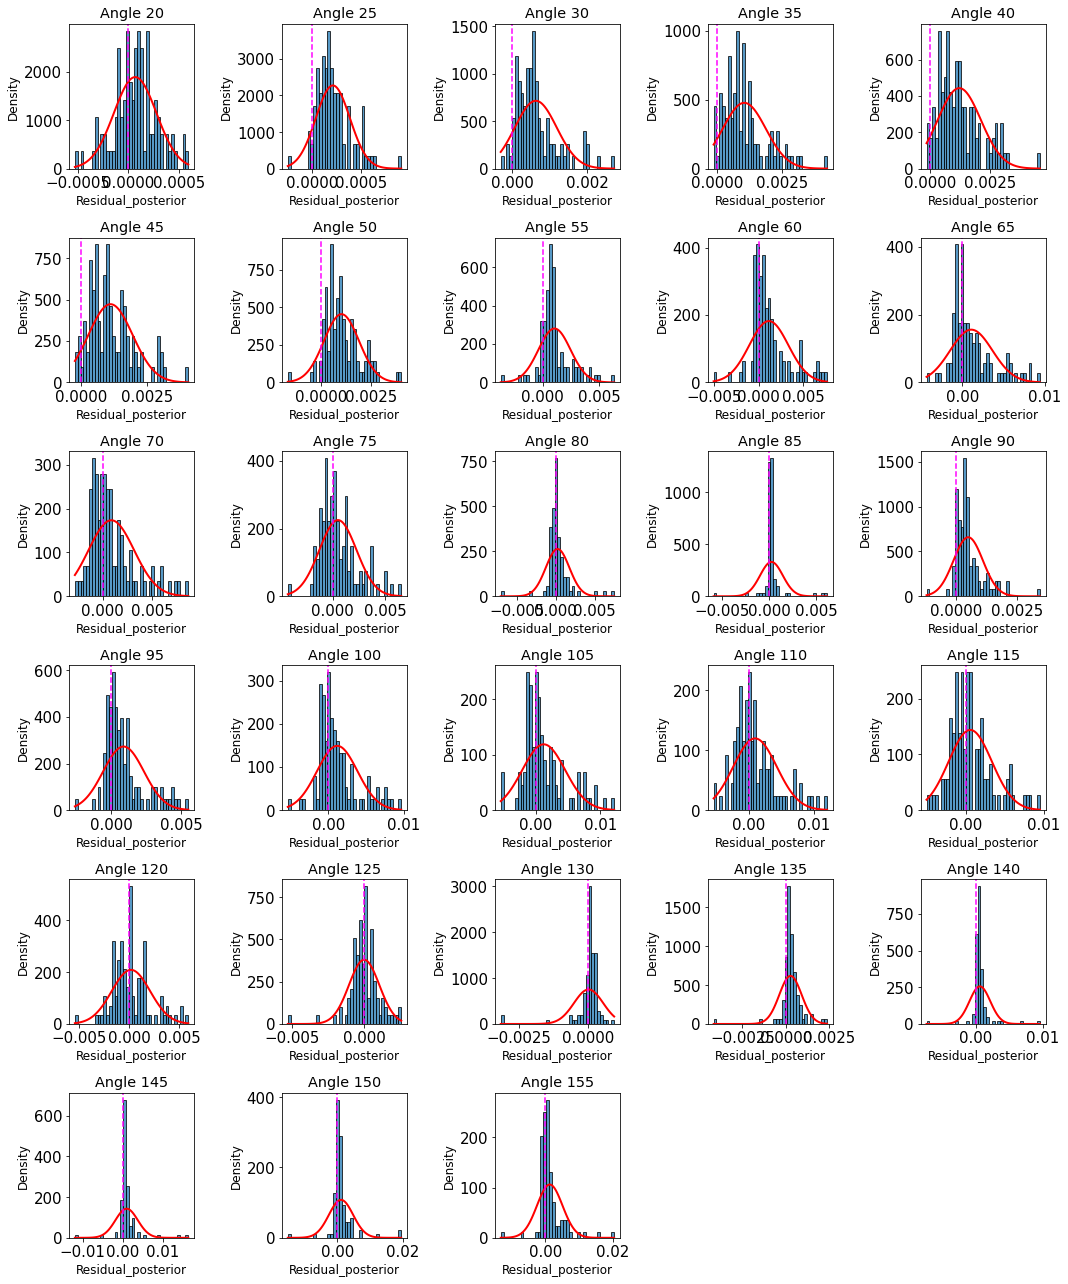

In [44]:

rmse_list_posterior=[]
residuals_posterior=np.array(residual_list_all_posterior).T[anglesX]



plots_per_row = 5
num_of_rows = len(residuals_posterior) // plots_per_row + (len(residuals_posterior) % plots_per_row > 0)

plt.rc("xtick", labelsize=15)
plt.rc("ytick", labelsize=15)

# Set up the figure size, you can adjust it as needed
plt.figure(figsize=(15, num_of_rows * 3))



# Loop over the list of residuals and create a histogram for each
for i, residual in enumerate(residuals_posterior):
    # Create a subplot for each histogram
    ax=plt.subplot(num_of_rows, plots_per_row, i + 1)
    
#     # Plot the histogram
#     plt.hist(residual, bins=20, alpha=0.75, edgecolor='black', density=True)
    
    # Plot the histogram and normalize it
    ax.hist(residual, bins=40, alpha=0.75, edgecolor='black', density=True)

    
    
    # Fit a Gaussian distribution to the residuals
    mu=np.mean(residuals_posterior[i])
    std = np.std(residuals_posterior[i])
    rmse_list_posterior.append(np.sqrt(mu**2+std**2))

    
    # Plot the Gaussian distribution
    xmin=np.min(residuals_posterior[i])
    xmax = np.max(residuals_posterior[i])

    x = np.linspace(xmin, xmax, 100)
    p = norm.pdf(x, mu, std)
    ax.plot(x, p, 'r', linewidth=2)
    
                     
                     
    ax.axvline(x=0, color='magenta', linestyle='--', linewidth=1.5)
    # Optional: Set a title or labels
    plt.title(f'Angle {anglesX[i]+1}')
    plt.xlabel('Residual_posterior')
    plt.ylabel('Density')
    # Optional: Set a tight layout so the plots are neatly arranged
    plt.tight_layout()

# Show the plot
plt.show()

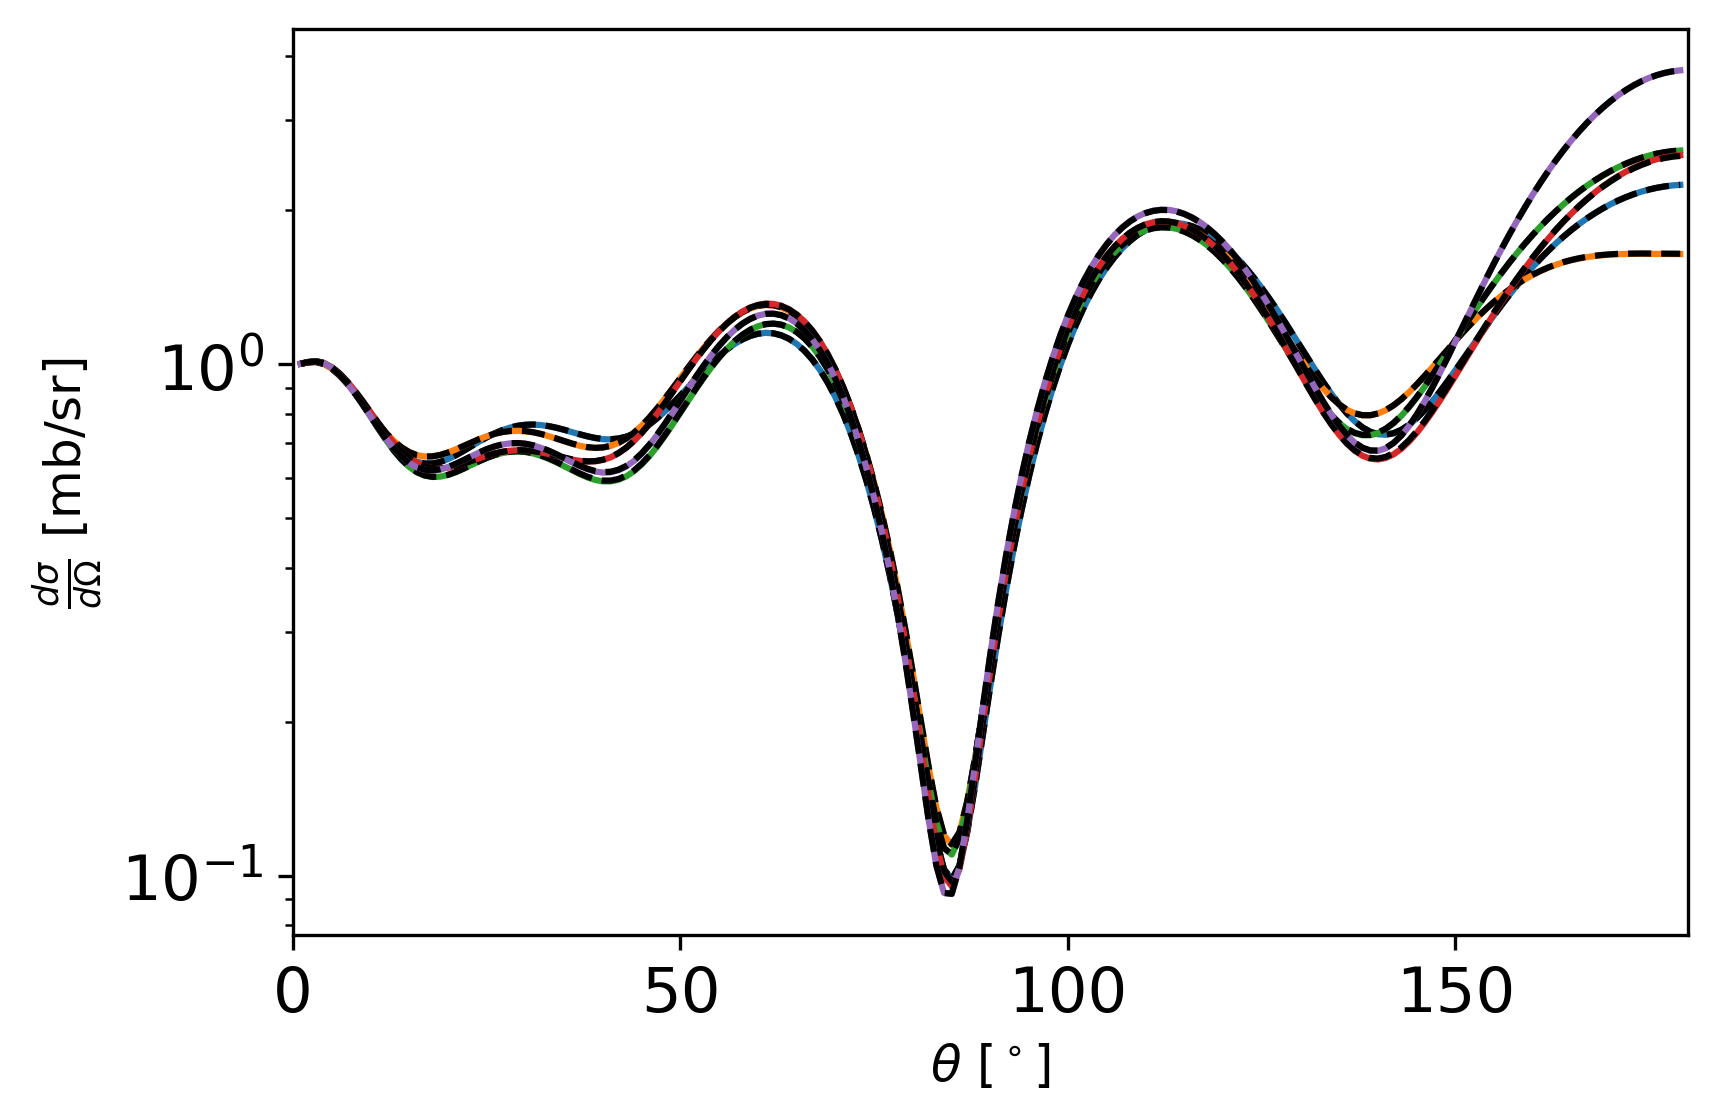

In [45]:
# now let's plot the differential scattering cross section for each of these samples test points!
fig, ax = plt.subplots(figsize=(6, 4), dpi=300)
fig.patch.set_facecolor("white")


for i in range(80,85):
    ax.plot(angles, test_CS_posterior[i])
    ax.plot(angles, prediction_list_posterior[i],color="k", linestyle="--")
ax.set_yscale("log")
plt.xlim([0, 180])
plt.xlabel(r"$\theta$ [$^\circ$]")
plt.ylabel(r"$\frac{d \sigma}{d \Omega}$ [mb/sr]")
plt.show()

In [46]:
[rmse_list_posterior[i]/yperfect[i]*100 for i in range(len(yperfect))]

[0.03750205184833704,
 0.04274048244830554,
 0.12327596388707841,
 0.19640545634070752,
 0.22168670710561245,
 0.18930572433542722,
 0.14943202066669778,
 0.16106157767430415,
 0.20297256890908405,
 0.24089696011808256,
 0.27167910494209646,
 0.34307072868835,
 0.7185192123479599,
 1.3216372038026385,
 0.3069352509800224,
 0.2536858912631228,
 0.23953094709719655,
 0.20633978296053582,
 0.1698633135024731,
 0.13495233878698618,
 0.1010086047766406,
 0.06820763968280964,
 0.04647547588471975,
 0.08464598522128788,
 0.2492390107952825,
 0.4030208678843891,
 0.3839364027722056,
 0.26977458167189045]

In [41]:
labelsChains = [
    "$V_v$",
    "$W_v$",
    "$W_d$",
    "$V_{so}$",
    "$W_{so}$",
    "$R_v$",
    "$R_d$",
    "$R_{so}$",
    "$a_v$",
    "$a_d$",
    "$a_{so}$",
]

Below we plot the parameters that all the chains, concatenated together, explored. The horizontal red lines are the KD values

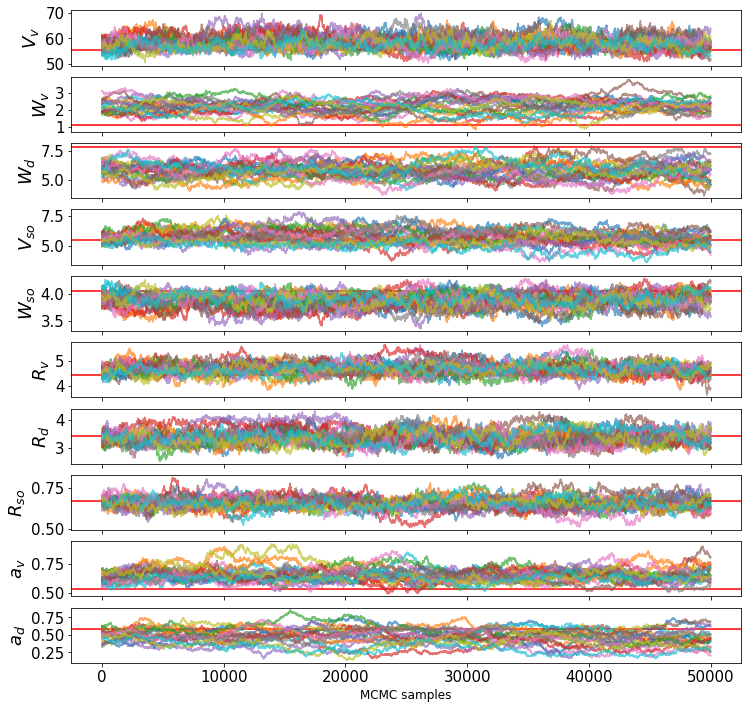

In [42]:
XAll = np.arange(len(anglesX))

plt.rc("xtick", labelsize=15)
plt.rc("ytick", labelsize=15)
fig, axs = plt.subplots(nparams, 1, figsize=(12, 12), sharex='all')

for i in range(nparams):
    axs[i].axhline(y=alphaKD[i],color='r')
    axs[i].plot(sep_chains[:, :, i].T, alpha=0.65)
    axs[i].set_ylabel(labelsChains[i], fontsize=18)

plt.xlabel('MCMC samples')
plt.show()

## Plotting our final calibrated model alongside the data

In [43]:
#Estimating the emulator error across all angles plotted
rmse_list_full=[]
residuals_full=residual_list_all.T

for i, residual in enumerate(residuals_full):

    mu=np.mean(residuals_full[i])
    std = np.std(residuals_full[i])
    rmse_list_full.append(np.sqrt(mu**2+std**2))

    

In [44]:
rmse_list_full=np.copy(rmse_list_full)

In [45]:
XAll = np.arange(len(anglesX))

In [47]:
# %#%time
rng = np.random.default_rng()
theta_rand = rng.choice(all_chains, (50000), replace=False)

In [48]:
%%time
rndm_m = []

for i in range(len(theta_rand)):
    yvals_rand=saeMCMC_fullangles.emulate_dsdo(theta_rand[i])
    rndm_m.append(yvals_rand +
                  np.random.multivariate_normal(np.full(
                       len(angles)
                       ,0), np.diag(
                       1.0 * np.square(yvals_rand*0.1) + np.square(yvals_rand*0.01)
                   )))   

CPU times: user 1h 17min 35s, sys: 2h 37min 33s, total: 3h 55min 9s
Wall time: 11min 45s


In [116]:
# rndm_m = rbm(XAll, theta_rand).mean().T

In [49]:
# KD_cs=saeMCMC_fullangles.emulate_dsdo(alphaKD)
KD_cs=saeMCMC_fullangles.exact_dsdo(alphaKD)


/home/pablo/.local/lib/python3.10/site-packages/rose/free_solutions.py:52: DeprecationWarning: scipy.misc.derivative is deprecated in SciPy v1.10.0; and will be completely removed in SciPy v1.12.0. You may consider using findiff: https://github.com/maroba/findiff or numdifftools: https://github.com/pbrod/numdifftools
  return derivative(lambda z: H_minus(z, ell, eta), rho, dx=dx)
/home/pablo/.local/lib/python3.10/site-packages/rose/free_solutions.py:45: DeprecationWarning: scipy.misc.derivative is deprecated in SciPy v1.10.0; and will be completely removed in SciPy v1.12.0. You may consider using findiff: https://github.com/maroba/findiff or numdifftools: https://github.com/pbrod/numdifftools
  return derivative(lambda z: H_plus(z, ell, eta), rho, dx=dx)


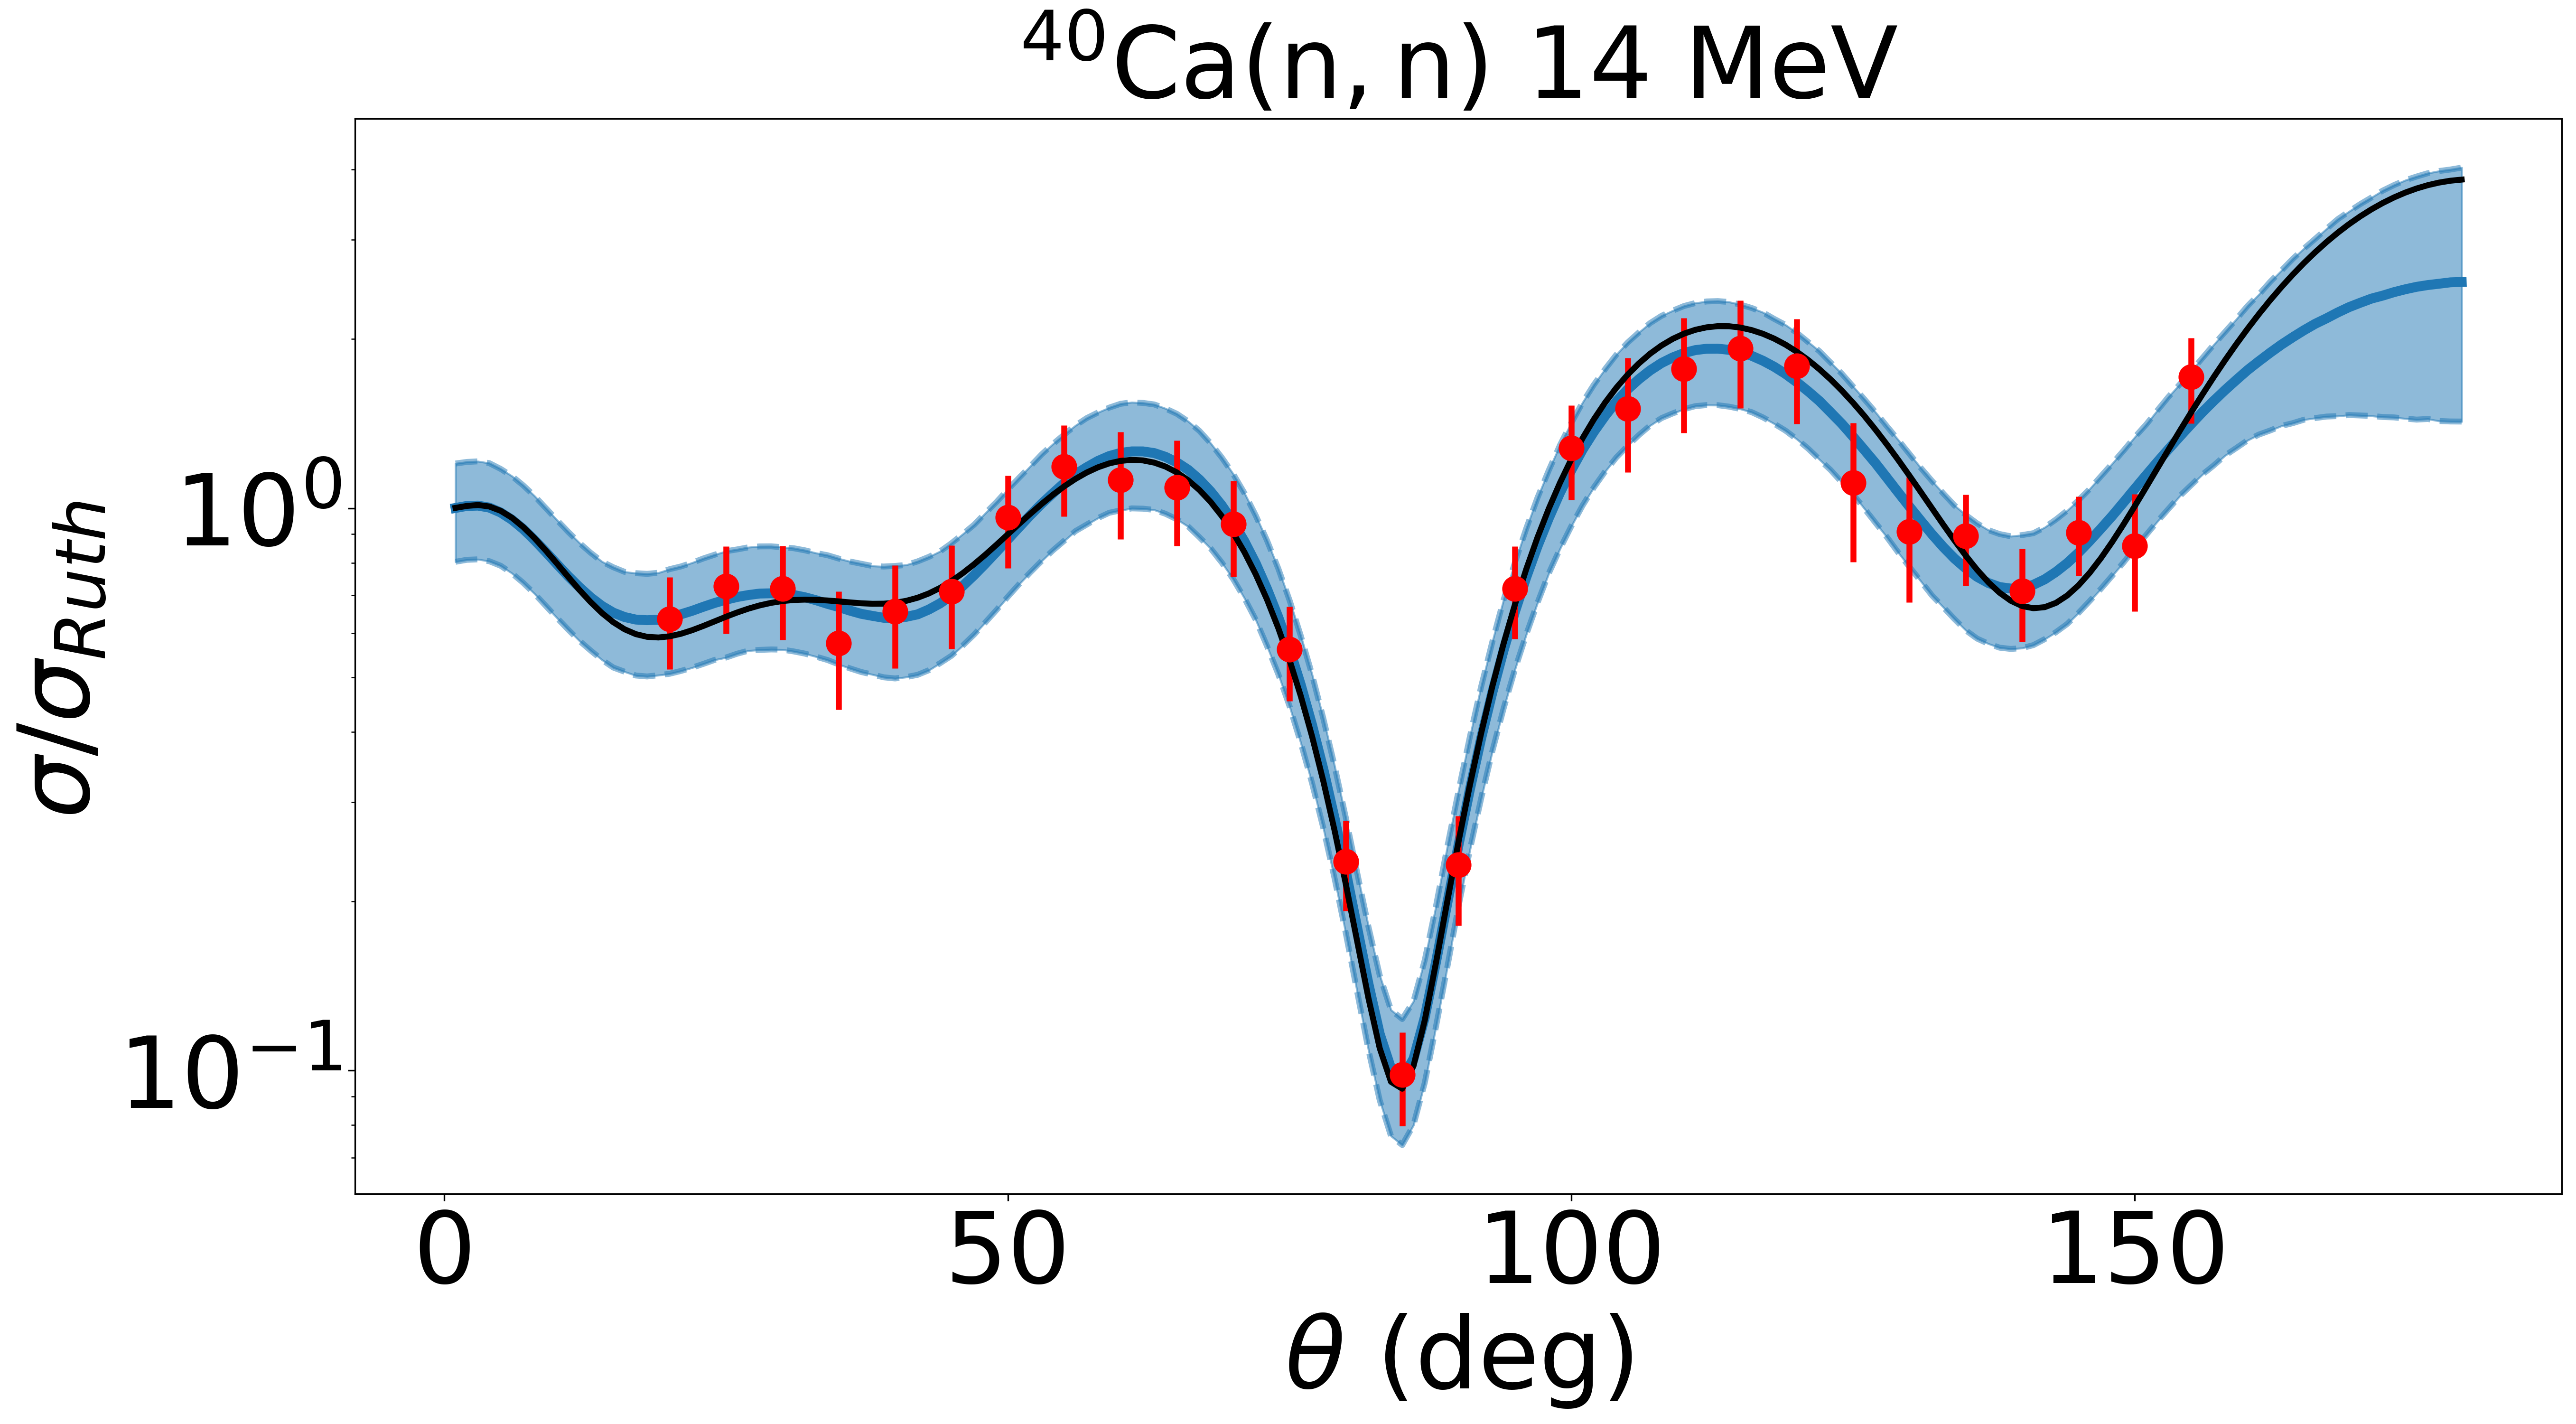

In [53]:

plt.rc("xtick", labelsize=50)  # fontsize of the tick labels
plt.rc("ytick", labelsize=50)

fig, axs = plt.subplots(1, 1, figsize=(20, 10),dpi=300)
median = np.percentile(rndm_m, 50, axis=0)
upper = np.abs(np.percentile(rndm_m, 97.5, axis=0))



lower = np.abs(np.percentile(rndm_m, 2.5, axis=0))

axs.plot(angles, median, color="C0", label='Median Prediction',linewidth=5)

axs.plot(angles, lower, color="C0",linestyle="dashed",linewidth=3,alpha=0.5)
axs.plot(angles, upper, color="C0",linestyle="dashed",linewidth=3,alpha=0.5)

axs.fill_between(angles, lower, upper, color="C0",alpha=0.5, label='95 percentile')

# axs.scatter(angles_theta, 10*y, s=150, c="r", label='Mock Data')
axs.errorbar(angles_theta, y, yerr=2 * yerr,linewidth=3,markersize=12, fmt="o", c="r",label='Mock Data (95%)')

axs.set_yscale("log")

axs.set_xlabel(r"$\theta$ (deg)", fontsize=50)
axs.set_ylabel(r"$\sigma/\sigma_{Ruth}$ ", fontsize=50)

axs.plot(angles, KD_cs, c="k",linewidth=3,label='True Function')


plt.title(r"$^{40}\rm{Ca}(n,n) \ 14\  MeV$", fontsize=50)



# plt.legend(fontsize='30')
plt.show()